# Group 11 _Phase 2 Submission

## Team Member 
Group 11 Team Members: Neelan Scheumann, Sha Liu, Ketan Pimparkar

The course project is based on the [Home Credit Default Risk (HCDR)  Kaggle Competition](https://www.kaggle.com/c/home-credit-default-risk/). The goal of this project is to predict whether or not a client will repay a loan. In order to make sure that people who struggle to get loans due to insufficient or non-existent credit histories have a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

## Data files overview
There are 7 different sources of data:

* __application_train/application_test:__ the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating __0: the loan was repaid__ or __1: the loan was not repaid__. The target variable defines if the client had payment difficulties meaning he/she had late payment more than X days on at least one of the first Y installments of the loan. Such case is marked as 1 while other all other cases as 0.
* __bureau:__ data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* __bureau_balance:__ monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* __previous_application:__ previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* __POS_CASH_BALANCE:__ monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* __installments_payment:__ payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

### Imports

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

### Load the Data

In [2]:
def load_data(in_path, name):
    df = pd.read_csv(in_path)
    print(f"{name}: shape is {df.shape}")
    print(df.info())
    display(df.head(5))
    return df

datasets={}  # lets store the datasets in a dictionary so we can keep track of them easily

ds_names = ("application_train", "application_test", "bureau","bureau_balance","credit_card_balance","installments_payments",
            "previous_application","POS_CASH_balance")

for ds_name in ds_names:
    datasets[ds_name] = load_data(f'data/{ds_name}.csv', ds_name)

application_train: shape is (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


application_test: shape is (48744, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


bureau: shape is (1716428, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int64
SK_ID_BUREAU              int64
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int64
CREDIT_DAY_OVERDUE        int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int64
AMT_ANNUITY               float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
None


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


bureau_balance: shape is (27299925, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
SK_ID_BUREAU      int64
MONTHS_BALANCE    int64
STATUS            object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
None


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


credit_card_balance: shape is (3840312, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int64
SK_ID_CURR                    int64
MONTHS_BALANCE                int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL       int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT          int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS          object
SK_DPD                        int64
SK_DPD_DEF          

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


installments_payments: shape is (13605401, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB
None


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


previous_application: shape is (1670214, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int64
SK_ID_CURR                     1670214 non-null int64
NAME_CONTRACT_TYPE             1670214 non-null object
AMT_ANNUITY                    1297979 non-null float64
AMT_APPLICATION                1670214 non-null float64
AMT_CREDIT                     1670213 non-null float64
AMT_DOWN_PAYMENT               774370 non-null float64
AMT_GOODS_PRICE                1284699 non-null float64
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int64
RATE_DOWN_PAYMENT              774370 non-null float64
RATE_INTEREST_PRIMARY          5951 non-null float64
RATE_INTEREST_PRIVILEGED       5951 non-null float64
NAME_CASH_LOAN_PURPOS

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


POS_CASH_balance: shape is (10001358, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int64
SK_ID_CURR               int64
MONTHS_BALANCE           int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS     object
SK_DPD                   int64
SK_DPD_DEF               int64
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
None


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [3]:
for ds_name in datasets.keys():
    print(f'dataset {ds_name:24}: [ {datasets[ds_name].shape[0]:10,}, {datasets[ds_name].shape[1]}]')


dataset application_train       : [    307,511, 122]
dataset application_test        : [     48,744, 121]
dataset bureau                  : [  1,716,428, 17]
dataset bureau_balance          : [ 27,299,925, 3]
dataset credit_card_balance     : [  3,840,312, 23]
dataset installments_payments   : [ 13,605,401, 8]
dataset previous_application    : [  1,670,214, 37]
dataset POS_CASH_balance        : [ 10,001,358, 8]


In [4]:
app_train = datasets['application_train']
app_test = datasets['application_test']

df_prev_app = datasets["previous_application"]
df_pos_cash = datasets['POS_CASH_balance']
df_pos_cash_latest = df_pos_cash.loc[df_pos_cash.groupby(['SK_ID_PREV','SK_ID_CURR'])['MONTHS_BALANCE'].idxmax()]  
bureau_df = datasets['bureau']
df_installments = datasets['installments_payments']
df_credit = datasets['credit_card_balance']

# Exploratory Data Analysis (EDA)

## Dataset: Application train

In [5]:
app_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [6]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [7]:
app_train.describe() #numerical only features

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


### Missing data for application train and test

In [8]:
percent = (app_train.isnull().sum()/app_train.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = app_train.isna().sum().sort_values(ascending = False)
missing_application_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Train Missing Count"])
missing_application_train_data.head(20)

,Percent,Train Missing Count
COMMONAREA_MEDI,69.87,214865
COMMONAREA_AVG,69.87,214865
COMMONAREA_MODE,69.87,214865
NONLIVINGAPARTMENTS_MODE,69.43,213514
NONLIVINGAPARTMENTS_MEDI,69.43,213514
NONLIVINGAPARTMENTS_AVG,69.43,213514
FONDKAPREMONT_MODE,68.39,210295
LIVINGAPARTMENTS_MEDI,68.35,210199
LIVINGAPARTMENTS_MODE,68.35,210199
LIVINGAPARTMENTS_AVG,68.35,210199


In [9]:
percent = (datasets["application_test"].isnull().sum()/datasets["application_test"].isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = datasets["application_test"].isna().sum().sort_values(ascending = False)
missing_application_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Test Missing Count"])
missing_application_train_data.head(20)

,Percent,Test Missing Count
COMMONAREA_MEDI,68.72,33495
COMMONAREA_AVG,68.72,33495
COMMONAREA_MODE,68.72,33495
NONLIVINGAPARTMENTS_MODE,68.41,33347
NONLIVINGAPARTMENTS_MEDI,68.41,33347
NONLIVINGAPARTMENTS_AVG,68.41,33347
FONDKAPREMONT_MODE,67.28,32797
LIVINGAPARTMENTS_AVG,67.25,32780
LIVINGAPARTMENTS_MEDI,67.25,32780
LIVINGAPARTMENTS_MODE,67.25,32780


### Distribution of the target column 

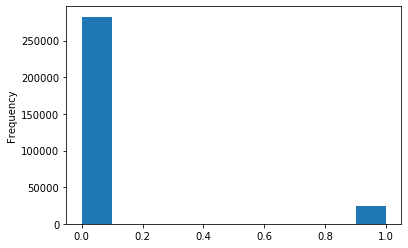

In [10]:
app_train['TARGET'].astype(int).plot.hist();

### Correlation with  the target column 

In [11]:
correlations = app_train.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


### Applicants Age 

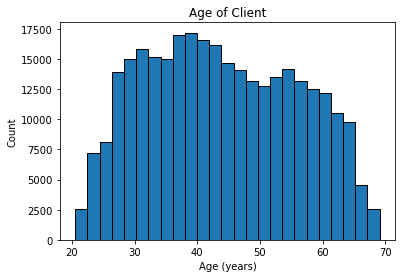

In [12]:
plt.hist(app_train['DAYS_BIRTH'] / -365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

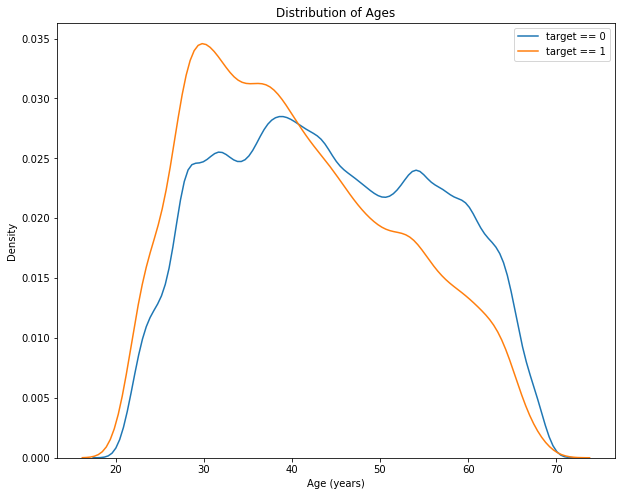

In [13]:
# By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable.
# To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. 

app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [14]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [15]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


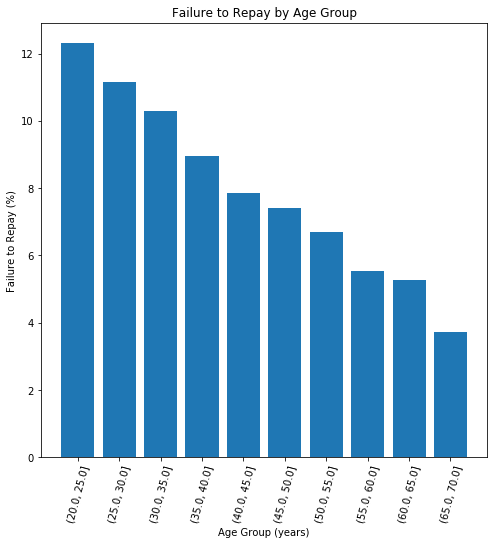

In [16]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### Applicants occupations

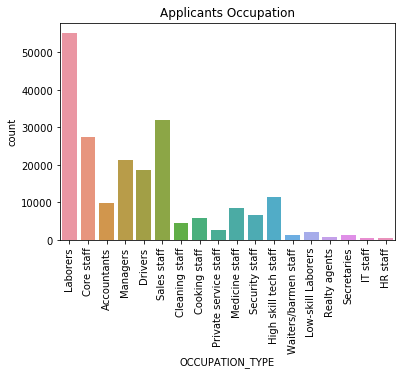

In [17]:
sns.countplot(x='OCCUPATION_TYPE', data=app_train);
plt.title('Applicants Occupation');
plt.xticks(rotation=90);

### Type of Organizations

In [18]:
app_train['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

There seem to be an awful lot of types of businesses that the applicants work for. None of them seem to be very intelligible either so grouping them into some higher level categories seems difficult. Perhaps this feature is better left out of the model.

### Applicants Gender

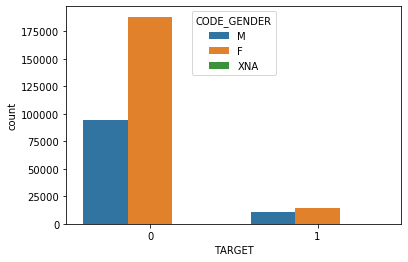

In [19]:
sns.countplot(app_train['TARGET'], hue = app_train['CODE_GENDER'])

### Type of Loan being Applied For

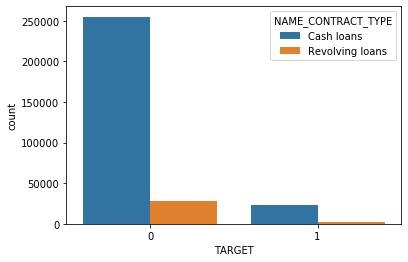

In [20]:
sns.countplot(app_train['TARGET'], hue = app_train['NAME_CONTRACT_TYPE'])

### Unique entries for categorical

In [21]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Anomalies

In [22]:
# Convert age in days to years
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean        -43.936973
std          11.956133
min         -69.120548
25%         -53.923288
50%         -43.150685
75%         -34.008219
max         -20.517808
Name: DAYS_BIRTH, dtype: float64

In [23]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

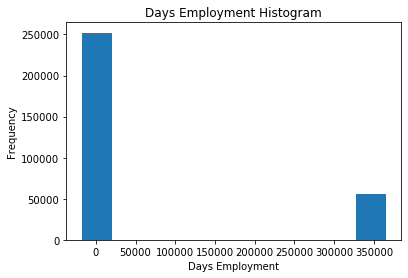

In [24]:
datasets["application_train"]['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [25]:
anom = datasets["application_train"][datasets["application_train"]['DAYS_EMPLOYED'] == 365243]
non_anom = datasets["application_train"][datasets["application_train"]['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


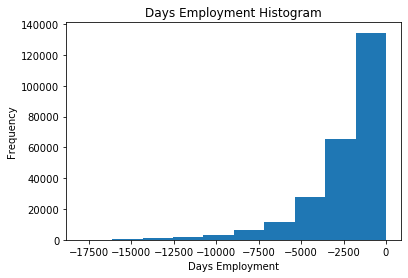

In [26]:
# Remove the anomalies and review the histogram again
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [27]:
# drop column DAYS_EMPLOYED_ANOM
app_train.drop(['DAYS_EMPLOYED_ANOM'], axis=1, inplace=True)
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataset: previous_application

Previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.


************************** previous_applications ******************************

Performing basic EDA on previous_applications dataset

* The dataset has 1670214 rows and 37 columns.

* First 10 rows of the dataset:



,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN



* Describing the dataset statistics:



,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000



* Fetching info of the dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int64
SK_ID_CURR                     1670214 non-null int64
NAME_CONTRACT_TYPE             1670214 non-null object
AMT_ANNUITY                    1297979 non-null float64
AMT_APPLICATION                1670214 non-null float64
AMT_CREDIT                     1670213 non-null float64
AMT_DOWN_PAYMENT               774370 non-null float64
AMT_GOODS_PRICE                1284699 non-null float64
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int64
RATE_DOWN_PAYMENT              774370 non-null float64
RATE_INTEREST_PRIMARY          5951 non-null float64
RATE_INTEREST_PRIVILEGED       5951 non-null float64
NAME_CASH_LOAN_PURPOSE         

None


* Check data distribution: 


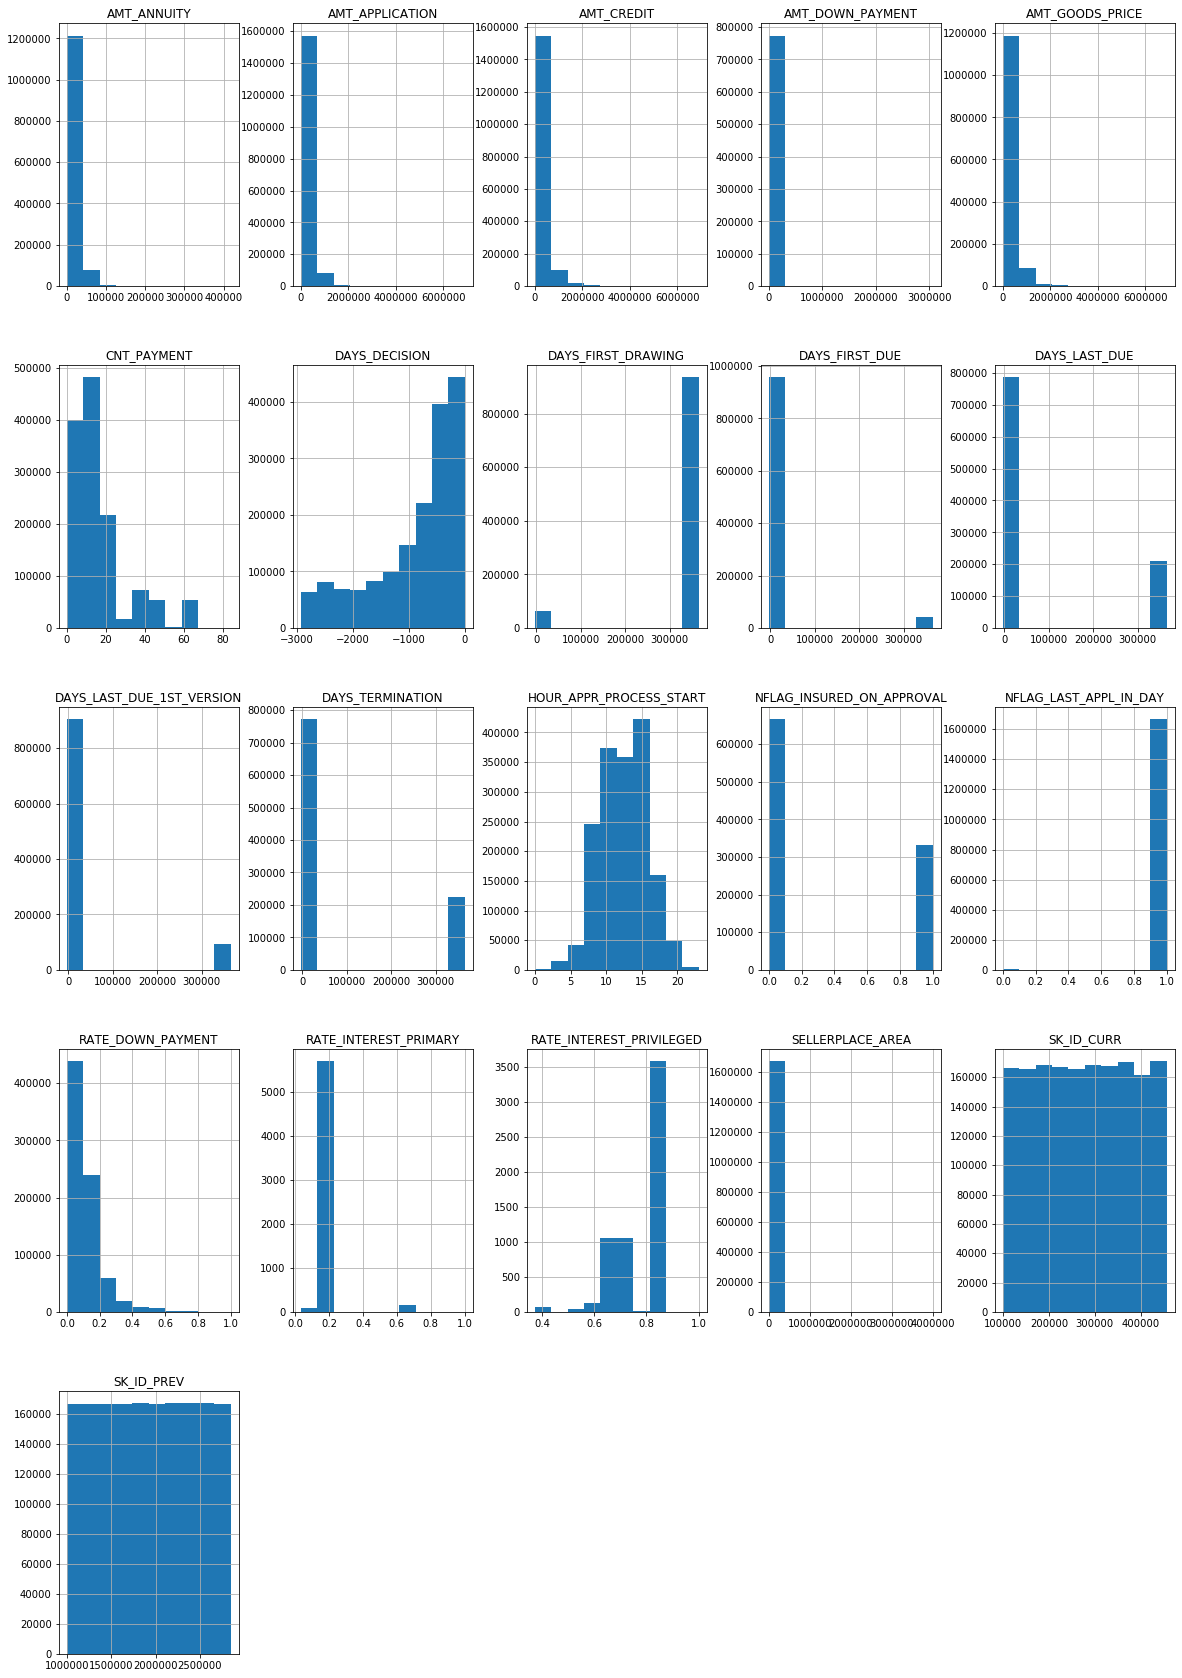

In [28]:
def basic_eda(df, datafile_name="Datafile name"):
    print(f"\n**************************",datafile_name,"******************************\n")
    print(f"Performing basic EDA on {datafile_name} dataset\n")
    print(f"* The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
    print("\n* First 10 rows of the dataset:\n")
    display(df.head(10))
    print("\n* Describing the dataset statistics:\n", )
    display(df.describe())
    print("\n* Fetching info of the dataset: \n")
    display(df.info())
    print("\n* Check data distribution: ")
    df.hist(figsize=(20,30))
    
    
df_prev_app = datasets["previous_application"]
basic_eda(df_prev_app, 'previous_applications')

### Unique Values

In [29]:
# SK_ID_PREV and SK_ID_CURR

In [30]:
print("* All records have distinct SK_ID_CURR? \t", len(df_prev_app['SK_ID_CURR'].unique()) == df_prev_app.shape[0])
print("* Total number of unique SK_ID_CURR   : \t", len(df_prev_app['SK_ID_CURR'].unique()))
print("* All records have distinct SK_ID_PREV? \t", len(df_prev_app['SK_ID_PREV'].unique()) == df_prev_app.shape[0])
print("* Total number of unique SK_ID_PREV   : \t", len(df_prev_app['SK_ID_PREV'].unique()))

* All records have distinct SK_ID_CURR? 	 False
* Total number of unique SK_ID_CURR   : 	 338857
* All records have distinct SK_ID_PREV? 	 True
* Total number of unique SK_ID_PREV   : 	 1670214


### Categorical variables

In [31]:
cat_features = ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION', 'NFLAG_INSURED_ON_APPROVAL']

************************************************** NAME_CONTRACT_TYPE ********************************************** 

NAME_CONTRACT_TYPE	has	0.0% nulls



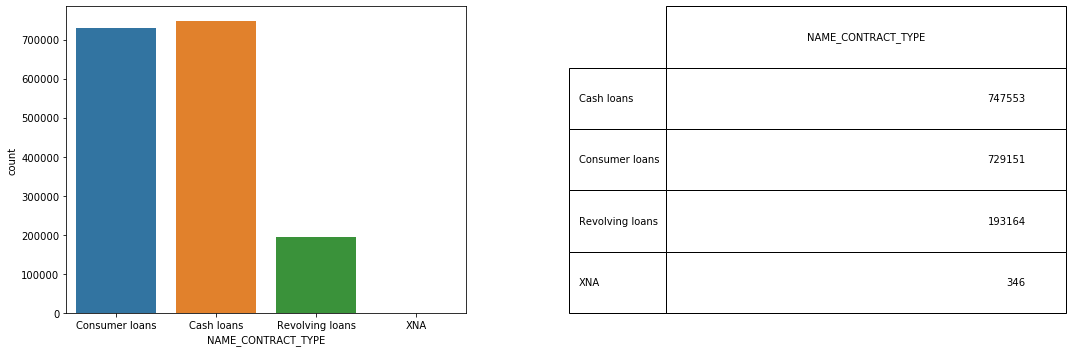

************************************************** WEEKDAY_APPR_PROCESS_START ********************************************** 

WEEKDAY_APPR_PROCESS_START	has	0.0% nulls



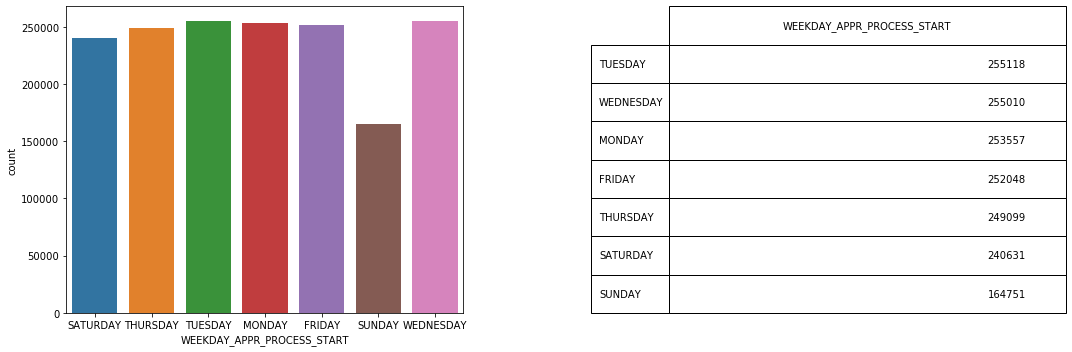

************************************************** HOUR_APPR_PROCESS_START ********************************************** 

HOUR_APPR_PROCESS_START	has	0.0% nulls



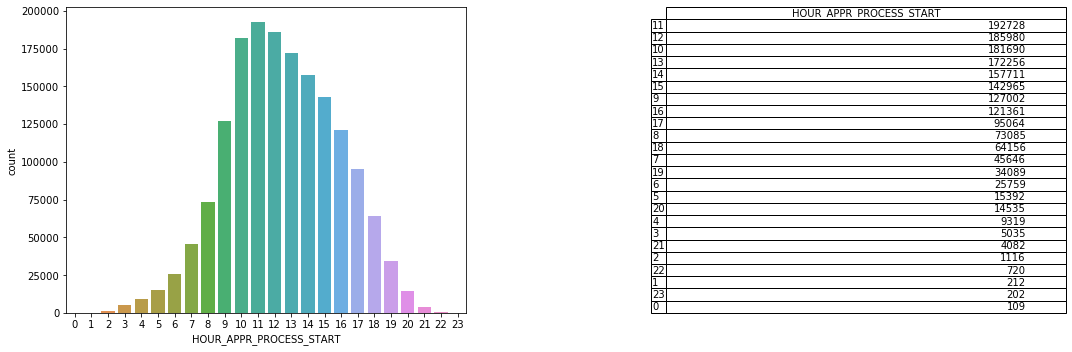

************************************************** NAME_CASH_LOAN_PURPOSE ********************************************** 

NAME_CASH_LOAN_PURPOSE	has	0.0% nulls



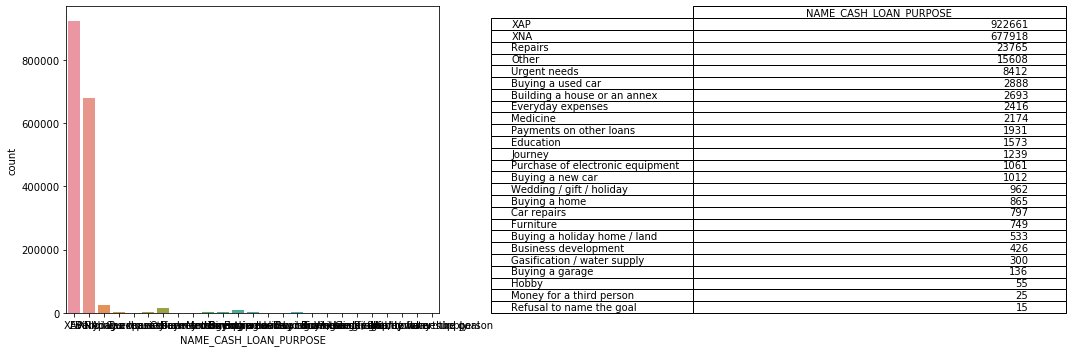

************************************************** NAME_CONTRACT_STATUS ********************************************** 

NAME_CONTRACT_STATUS	has	0.0% nulls



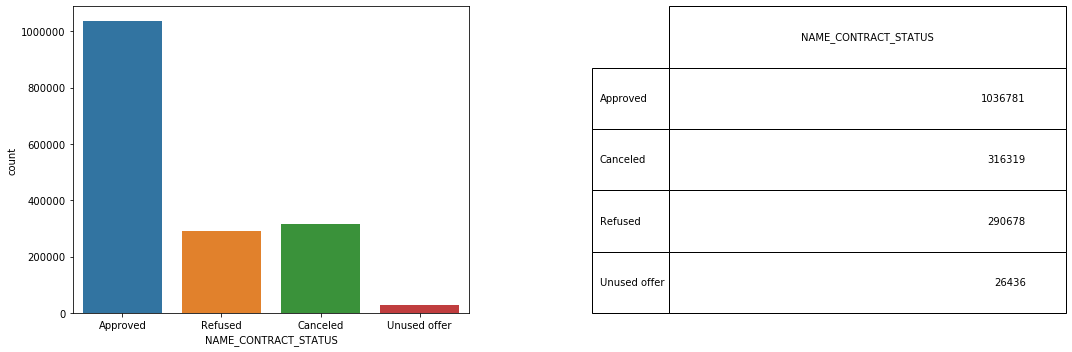

************************************************** NAME_PAYMENT_TYPE ********************************************** 

NAME_PAYMENT_TYPE	has	0.0% nulls



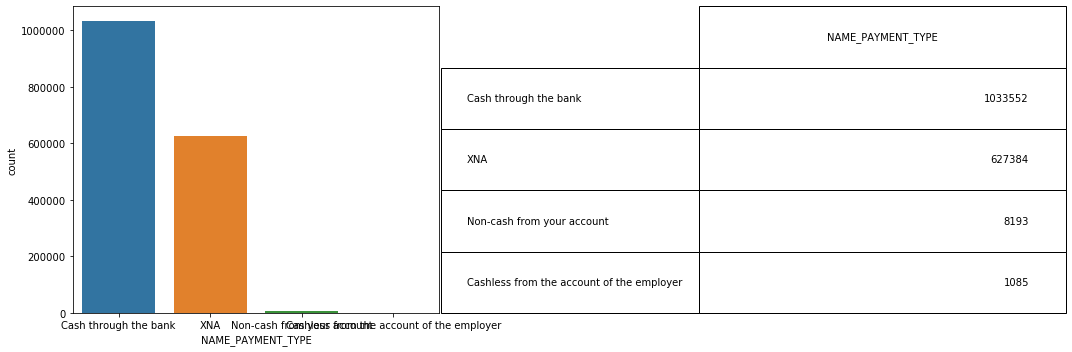

************************************************** CODE_REJECT_REASON ********************************************** 

CODE_REJECT_REASON	has	0.0% nulls



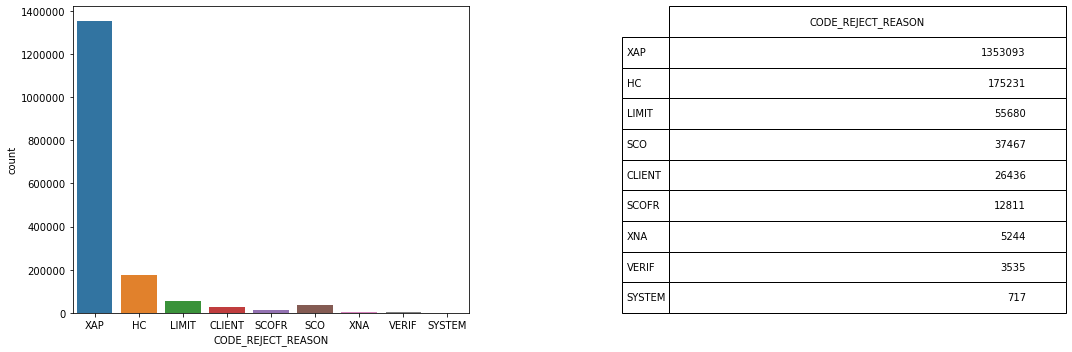

************************************************** NAME_CLIENT_TYPE ********************************************** 

NAME_CLIENT_TYPE	has	0.0% nulls



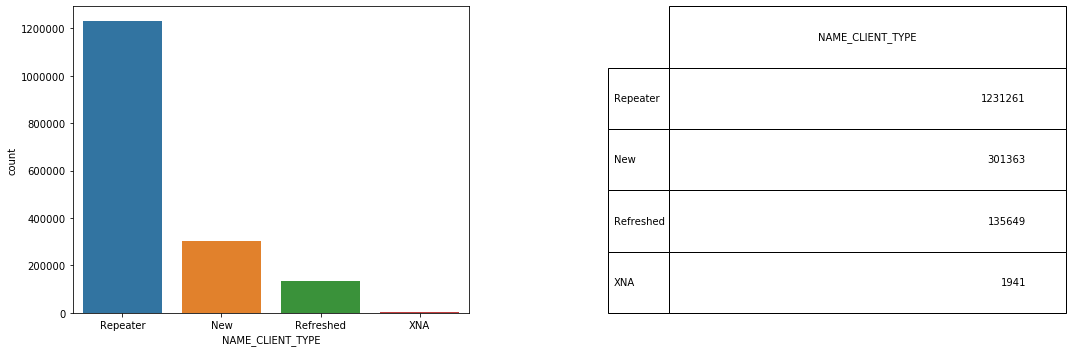

************************************************** NAME_GOODS_CATEGORY ********************************************** 

NAME_GOODS_CATEGORY	has	0.0% nulls



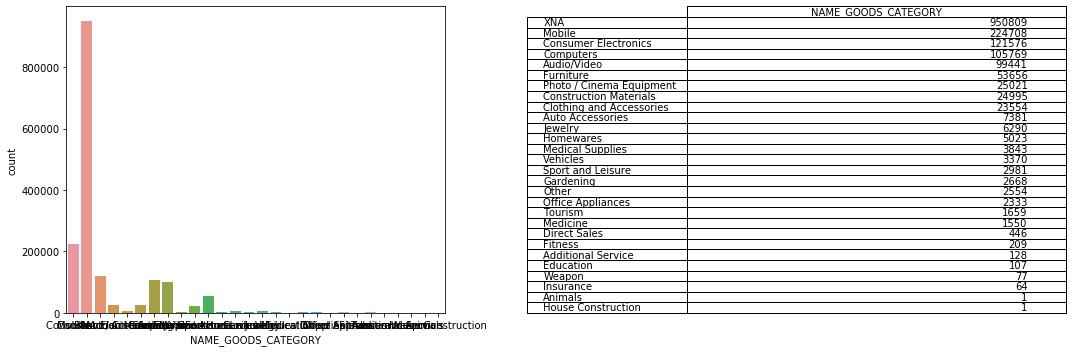

************************************************** CHANNEL_TYPE ********************************************** 

CHANNEL_TYPE	has	0.0% nulls



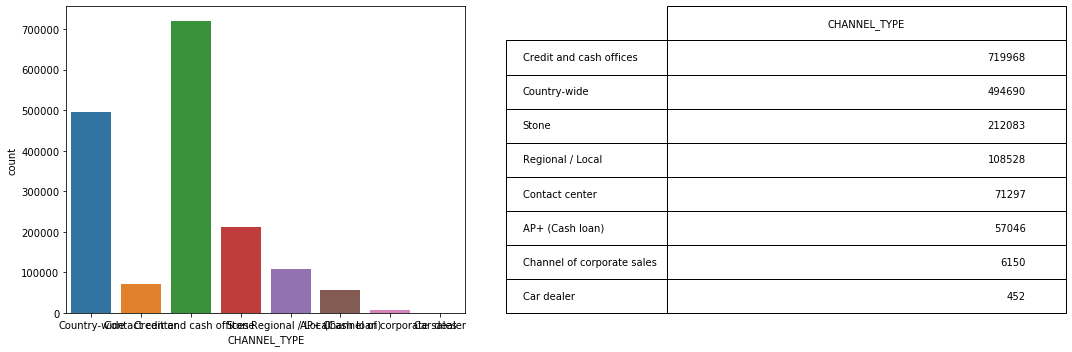

************************************************** NAME_SELLER_INDUSTRY ********************************************** 

NAME_SELLER_INDUSTRY	has	0.0% nulls



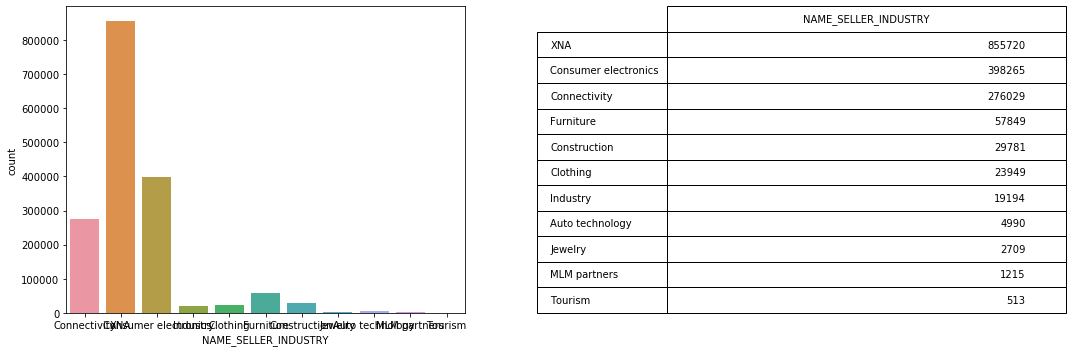

************************************************** PRODUCT_COMBINATION ********************************************** 

PRODUCT_COMBINATION	has	0.02071590826085759% nulls



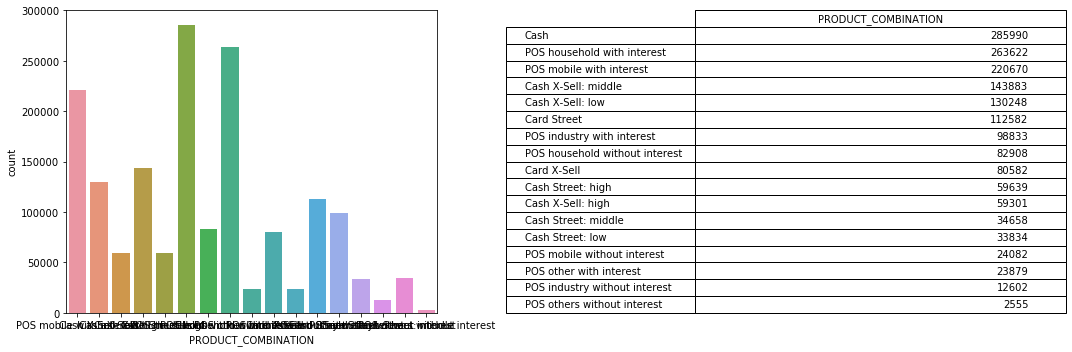

************************************************** NFLAG_INSURED_ON_APPROVAL ********************************************** 

NFLAG_INSURED_ON_APPROVAL	has	40.29812946125467% nulls



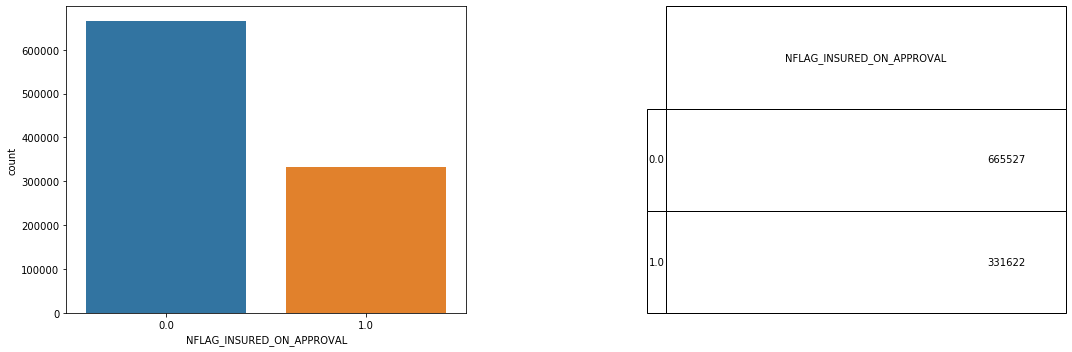

In [32]:
for attr in cat_features:
    print("*"*50, attr, "*"*46, "\n")
    print(f"{attr}\thas\t{(df_prev_app[attr].isna().sum()/ df_prev_app.shape[0])*100}% nulls\n")
    
    y = df_prev_app[attr].value_counts().to_frame()
    
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(121)
    sns.countplot(x=attr, data=df_prev_app)

    ax2 = fig.add_subplot(122)
    font_size=10
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = y.values, rowLabels = y.index, bbox=bbox, colLabels=y.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    plt.tight_layout(w_pad=20)
    plt.show()


In [33]:
percent = (df_prev_app.isnull().sum()/df_prev_app.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = df_prev_app.isna().sum().sort_values(ascending = False)
missing_application_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Train Missing Count"])
missing_application_train_data.head(20)

,Percent,Train Missing Count
RATE_INTEREST_PRIVILEGED,99.64,1664263
RATE_INTEREST_PRIMARY,99.64,1664263
RATE_DOWN_PAYMENT,53.64,895844
AMT_DOWN_PAYMENT,53.64,895844
NAME_TYPE_SUITE,49.12,820405
DAYS_TERMINATION,40.30,673065
NFLAG_INSURED_ON_APPROVAL,40.30,673065
DAYS_FIRST_DRAWING,40.30,673065
DAYS_FIRST_DUE,40.30,673065
DAYS_LAST_DUE_1ST_VERSION,40.30,673065


### Correlation of features

In [34]:
# Dropping columns RATE_INTEREST_PRIVILEGED and RATE_INTEREST_PRIMARY as these have more than 99% data missing
df_prev_app.drop(['RATE_INTEREST_PRIVILEGED','RATE_INTEREST_PRIMARY'],axis=1, inplace=True)

# Create correlation matrix
corr_matrix = df_prev_app.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print("Dropping: ", to_drop)
# Drop features 
df_prev_app_new = df_prev_app.drop(df_prev_app[to_drop], axis=1)

df_prev_app_new.head()

Dropping:  ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_TERMINATION']


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_DOWN_PAYMENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,...,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,0.0,SATURDAY,15,Y,1,...,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,NaN,THURSDAY,11,Y,1,...,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,NaN,TUESDAY,11,Y,1,...,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,NaN,MONDAY,7,Y,1,...,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,NaN,THURSDAY,9,Y,1,...,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN


In [35]:
len(np.intersect1d(datasets["previous_application"]["SK_ID_CURR"], datasets["application_test"]["SK_ID_CURR"]))

47800

In [36]:
sum(df_prev_app['SK_ID_CURR'].value_counts()==1)

60458

Text(0.5, 1.0, 'Histogram of Number of previous applications for an ID')

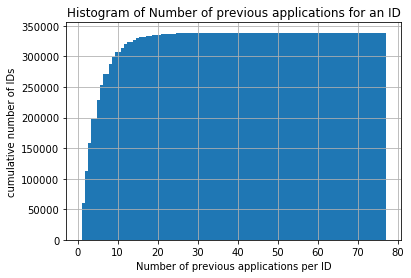

In [37]:
plt.hist(df_prev_app['SK_ID_CURR'].value_counts(), cumulative =True, bins = 100);
plt.grid()
plt.ylabel('cumulative number of IDs')
plt.xlabel('Number of previous applications per ID')
plt.title('Histogram of Number of previous applications for an ID')


In [38]:
apps_all = df_prev_app['SK_ID_CURR'].nunique()
apps_5plus = df_prev_app['SK_ID_CURR'].value_counts()>=5
apps_40plus = df_prev_app['SK_ID_CURR'].value_counts()>=40
print('Percentage with 10 or more previous apps:', np.round(100.*(sum(apps_5plus)/apps_all),5))
print('Percentage with 40 or more previous apps:', np.round(100.*(sum(apps_40plus)/apps_all),5))

Percentage with 10 or more previous apps: 41.76895
Percentage with 40 or more previous apps: 0.03453


## Dataset: POS_CASH_BALANCE

Monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.


************************** POS_CASH_balance ******************************

Performing basic EDA on POS_CASH_balance dataset

* The dataset has 10001358 rows and 8 columns.

* First 10 rows of the dataset:



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0
8,1220500,112740,-31,12.0,12.0,Active,0,0
9,2371489,274851,-32,24.0,16.0,Active,0,0



* Describing the dataset statistics:



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03



* Fetching info of the dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int64
SK_ID_CURR               int64
MONTHS_BALANCE           int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS     object
SK_DPD                   int64
SK_DPD_DEF               int64
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


None


* Check data distribution: 


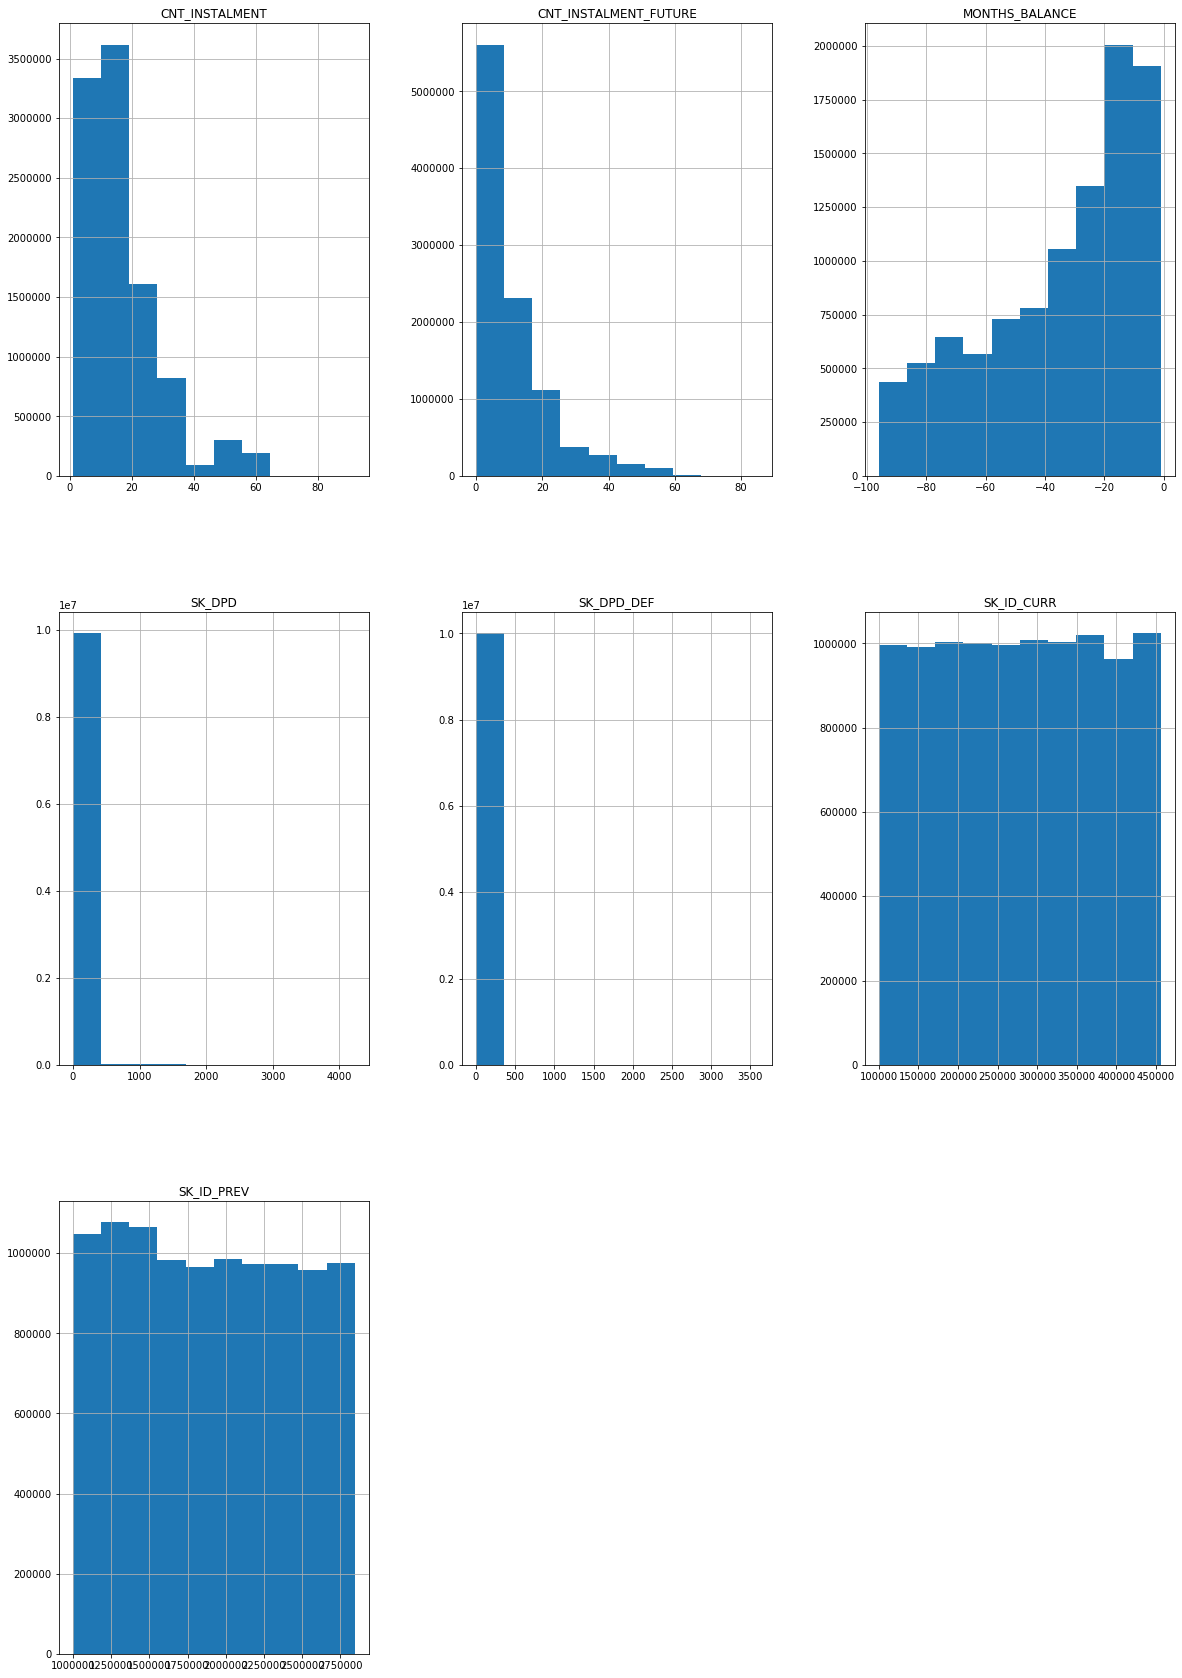

In [39]:
df_pos_cash = datasets['POS_CASH_balance']
basic_eda(df_pos_cash, 'POS_CASH_balance')

### SK_DPD and SK_DPD_DEF

In [40]:
print("* Values of SK_DPD\n")
# display(df_pos_cash['SK_DPD'].value_counts())
display(df_pos_cash['SK_DPD'].groupby(pd.cut(df_pos_cash['SK_DPD'],[0,100,200,500,1000,2000,5000])).count())

print("* Values of SK_DPD_DEF\n")
# display(df_pos_cash['SK_DPD_DEF'].value_counts())
display(df_pos_cash['SK_DPD_DEF'].groupby(pd.cut(df_pos_cash['SK_DPD_DEF'],[0,100,200,500,1000,2000,5000])).count())

# display(df_pos_cash[df_pos_cash['SK_DPD']==4231])
# display(df_pos_cash[df_pos_cash['SK_DPD_DEF']==3595])

* Values of SK_DPD



SK_DPD
(0, 100]        177723
(100, 200]       13456
(200, 500]       28144
(500, 1000]      30111
(1000, 2000]     31903
(2000, 5000]     13890
Name: SK_DPD, dtype: int64

* Values of SK_DPD_DEF



SK_DPD_DEF
(0, 100]        109343
(100, 200]         356
(200, 500]         734
(500, 1000]       1070
(1000, 2000]      1402
(2000, 5000]      1064
Name: SK_DPD_DEF, dtype: int64

Text(0.5, 1.0, 'Distribution of SK_DPD_DEF')

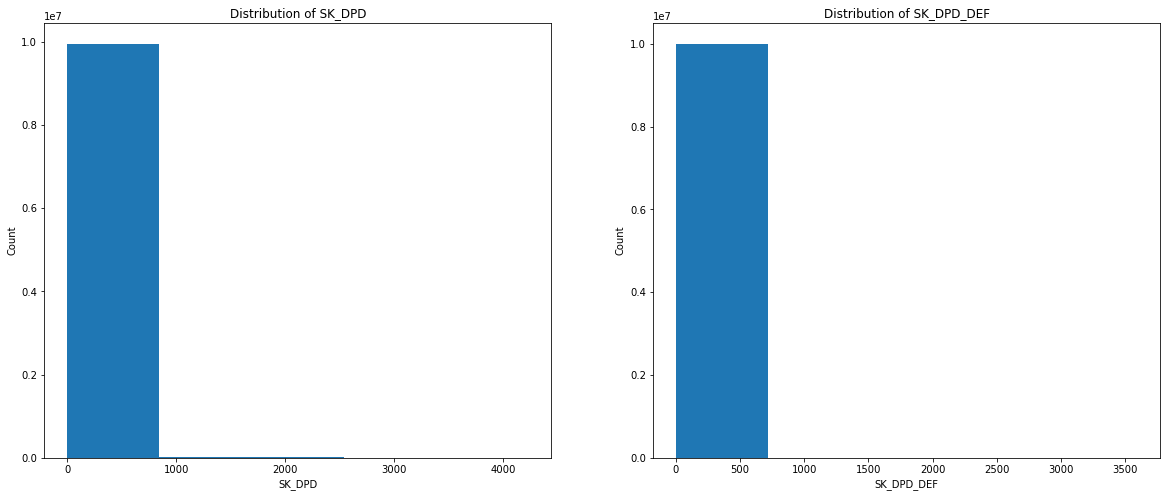

In [41]:
plt.figure(figsize=(20,8))
plt.subplot(121)
_ = plt.hist(df_pos_cash['SK_DPD'], bins=5)
plt.xlabel("SK_DPD")
plt.ylabel("Count")
plt.title("Distribution of SK_DPD")
plt.subplot(122)
_ = plt.hist(df_pos_cash['SK_DPD_DEF'], bins=5)
plt.xlabel("SK_DPD_DEF")
plt.ylabel("Count")
plt.title("Distribution of SK_DPD_DEF")

In [42]:
print(f"* SK_DPD and SK_DPD_DEF are different for {len(df_pos_cash[df_pos_cash.SK_DPD != df_pos_cash.SK_DPD_DEF])} records")

* SK_DPD and SK_DPD_DEF are different for 183880 records


### NAME_CONTRACT_STATUS

In [43]:
# This gives us latest record of each loan
# MONTHS_BALANCE has 0 for current, -1 for previous etc.
# Value of -8 in this field means 8 months back the loan was completed.

df_pos_cash_latest = df_pos_cash.loc[df_pos_cash.groupby(['SK_ID_PREV','SK_ID_CURR'])['MONTHS_BALANCE'].idxmax()]   

df_pos_cash_latest.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
45995,1000001,158271,-8,2.0,0.0,Completed,0,0
2792302,1000002,101962,-50,4.0,0.0,Completed,0,0
7085917,1000003,252457,-1,12.0,9.0,Active,0,0
4078063,1000004,260094,-22,7.0,0.0,Completed,0,0
7852623,1000005,176456,-46,10.0,0.0,Completed,0,0


In [44]:
df_pos_cash_latest['NAME_CONTRACT_STATUS'].value_counts()

Completed                698421
Active                   236149
Signed                     1272
Returned to the store       304
Demand                      102
Approved                     58
Amortized debt               17
Canceled                      2
Name: NAME_CONTRACT_STATUS, dtype: int64

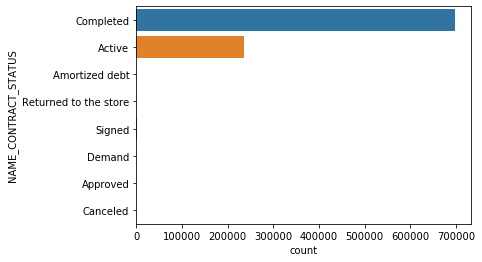

In [45]:
sns.countplot(y='NAME_CONTRACT_STATUS', data=df_pos_cash_latest)

## Dataset: Bureau


************************** bureau ******************************

Performing basic EDA on bureau dataset

* The dataset has 1716428 rows and 17 columns.

* First 10 rows of the dataset:



,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,Credit card,-690,NaN



* Describing the dataset statistics:



,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08



* Fetching info of the dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int64
SK_ID_BUREAU              int64
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int64
CREDIT_DAY_OVERDUE        int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int64
AMT_ANNUITY               float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


None


* Check data distribution: 


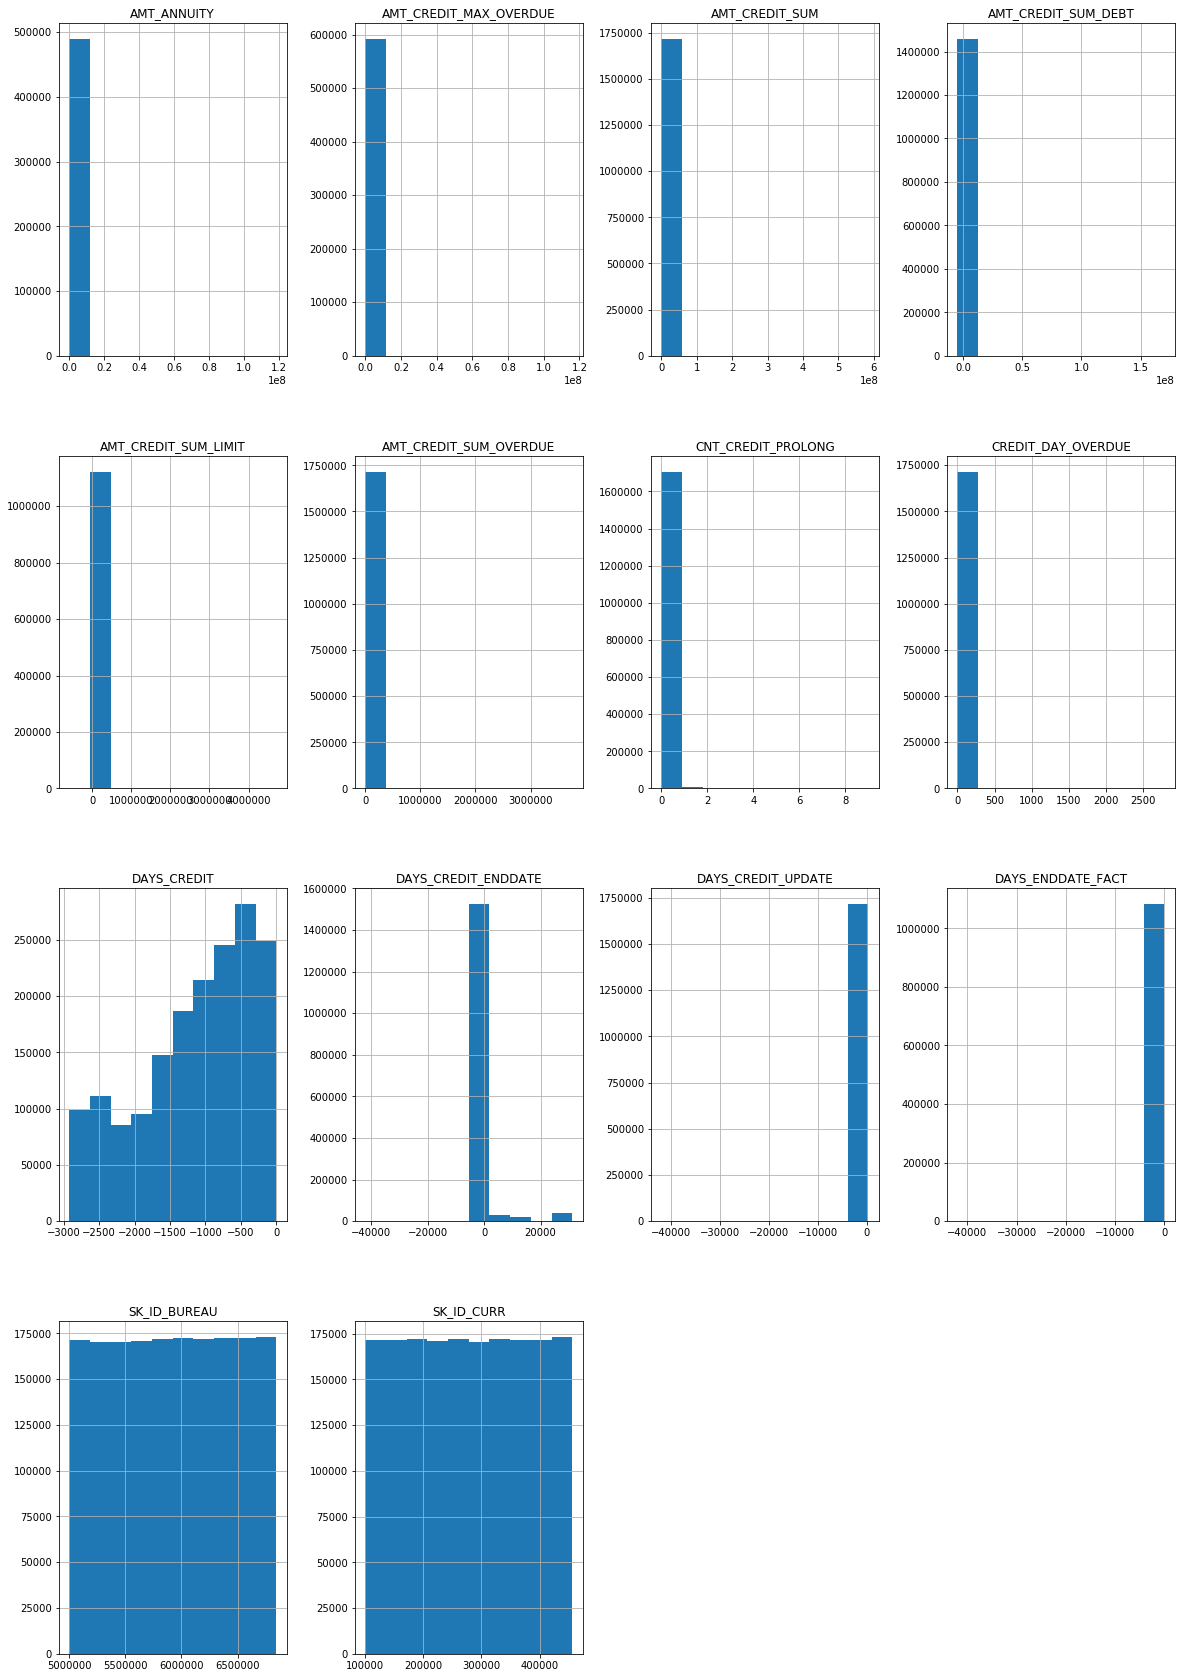

In [46]:
bureau_df = datasets['bureau']
basic_eda(bureau_df, 'bureau')

In [47]:
# Number of unqiue SK_IDs
len(bureau_df['SK_ID_CURR'].unique())

305811

In [48]:
cat_features = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

************************************************** CREDIT_ACTIVE ********************************************** 

CREDIT_ACTIVE	has	0.0% nulls



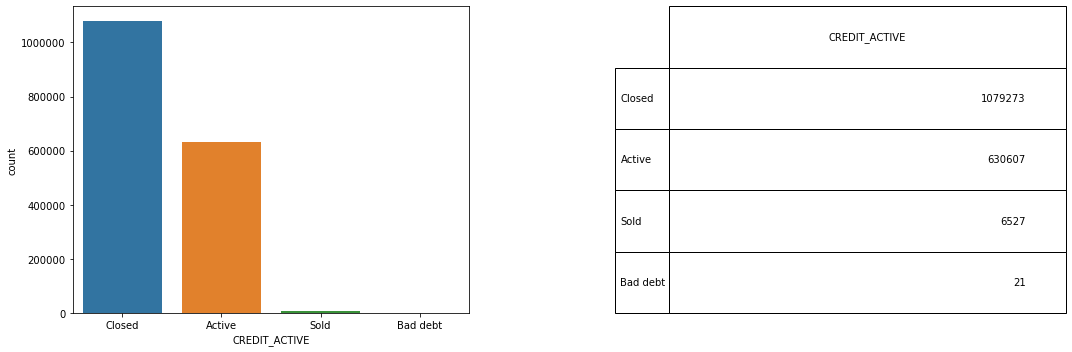

************************************************** CREDIT_CURRENCY ********************************************** 

CREDIT_CURRENCY	has	0.0% nulls



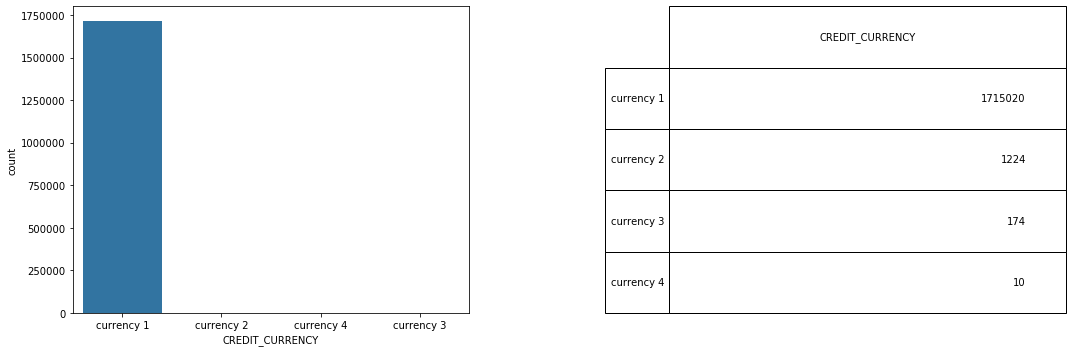

************************************************** CREDIT_TYPE ********************************************** 

CREDIT_TYPE	has	0.0% nulls



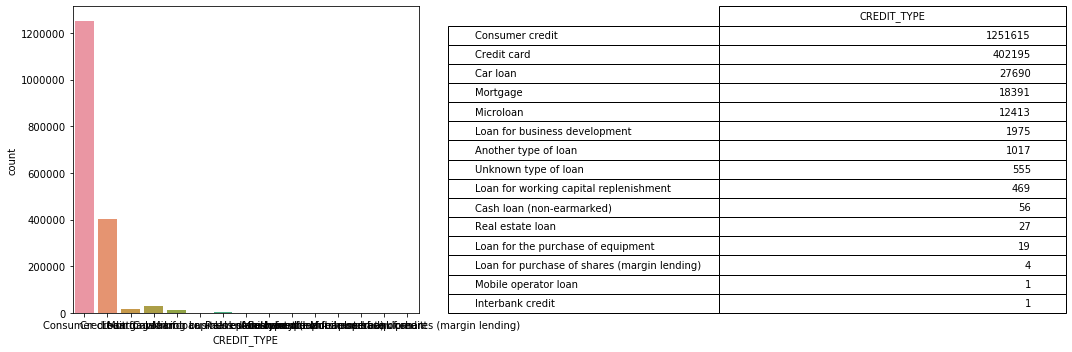

In [49]:
for attr in cat_features:
    print("*"*50, attr, "*"*46, "\n")
    print(f"{attr}\thas\t{(bureau_df[attr].isna().sum()/ bureau_df.shape[0])*100}% nulls\n")
    
    y = bureau_df[attr].value_counts().to_frame()
    
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(121)
    sns.countplot(x=attr, data=bureau_df)

    ax2 = fig.add_subplot(122)
    font_size=10
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = y.values, rowLabels = y.index, bbox=bbox, colLabels=y.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    plt.tight_layout(w_pad=20)
    plt.show()

In [50]:
bureau_df.groupby('SK_ID_CURR').sum()['AMT_CREDIT_SUM_DEBT'].describe()

count    3.058110e+05
mean     6.539142e+05
std      1.640691e+06
min     -6.981558e+06
25%      0.000000e+00
50%      1.733670e+05
75%      6.765412e+05
max      3.344983e+08
Name: AMT_CREDIT_SUM_DEBT, dtype: float64

## Dataset: credit_card_balance


************************** credit_card_balance ******************************

Performing basic EDA on credit_card_balance dataset

* The dataset has 3840312 rows and 23 columns.

* First 10 rows of the dataset:



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.500,0.0,877.500,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.000,0.0,0.000,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.000,0.0,0.000,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.000,0.0,0.000,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.000,0.0,11547.000,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.815,270000,0.0,0.000,0.0,0.000,4449.105,...,82773.315,82773.315,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.645,585000,67500.0,67500.000,0.0,0.000,14684.175,...,351881.145,351881.145,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125,45000,45000.0,45000.000,0.0,0.000,0.000,...,47962.125,47962.125,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.075,292500,90000.0,289339.425,0.0,199339.425,130.500,...,286831.575,286831.575,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.195,225000,76500.0,111026.700,0.0,34526.700,6338.340,...,197224.695,197224.695,3.0,9,0.0,6.0,38.0,Active,0,0



* Describing the dataset statistics:



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03



* Fetching info of the dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int64
SK_ID_CURR                    int64
MONTHS_BALANCE                int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL       int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT          int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS          object
SK_DPD                        int64
SK_DPD_DEF                   

None


* Check data distribution: 


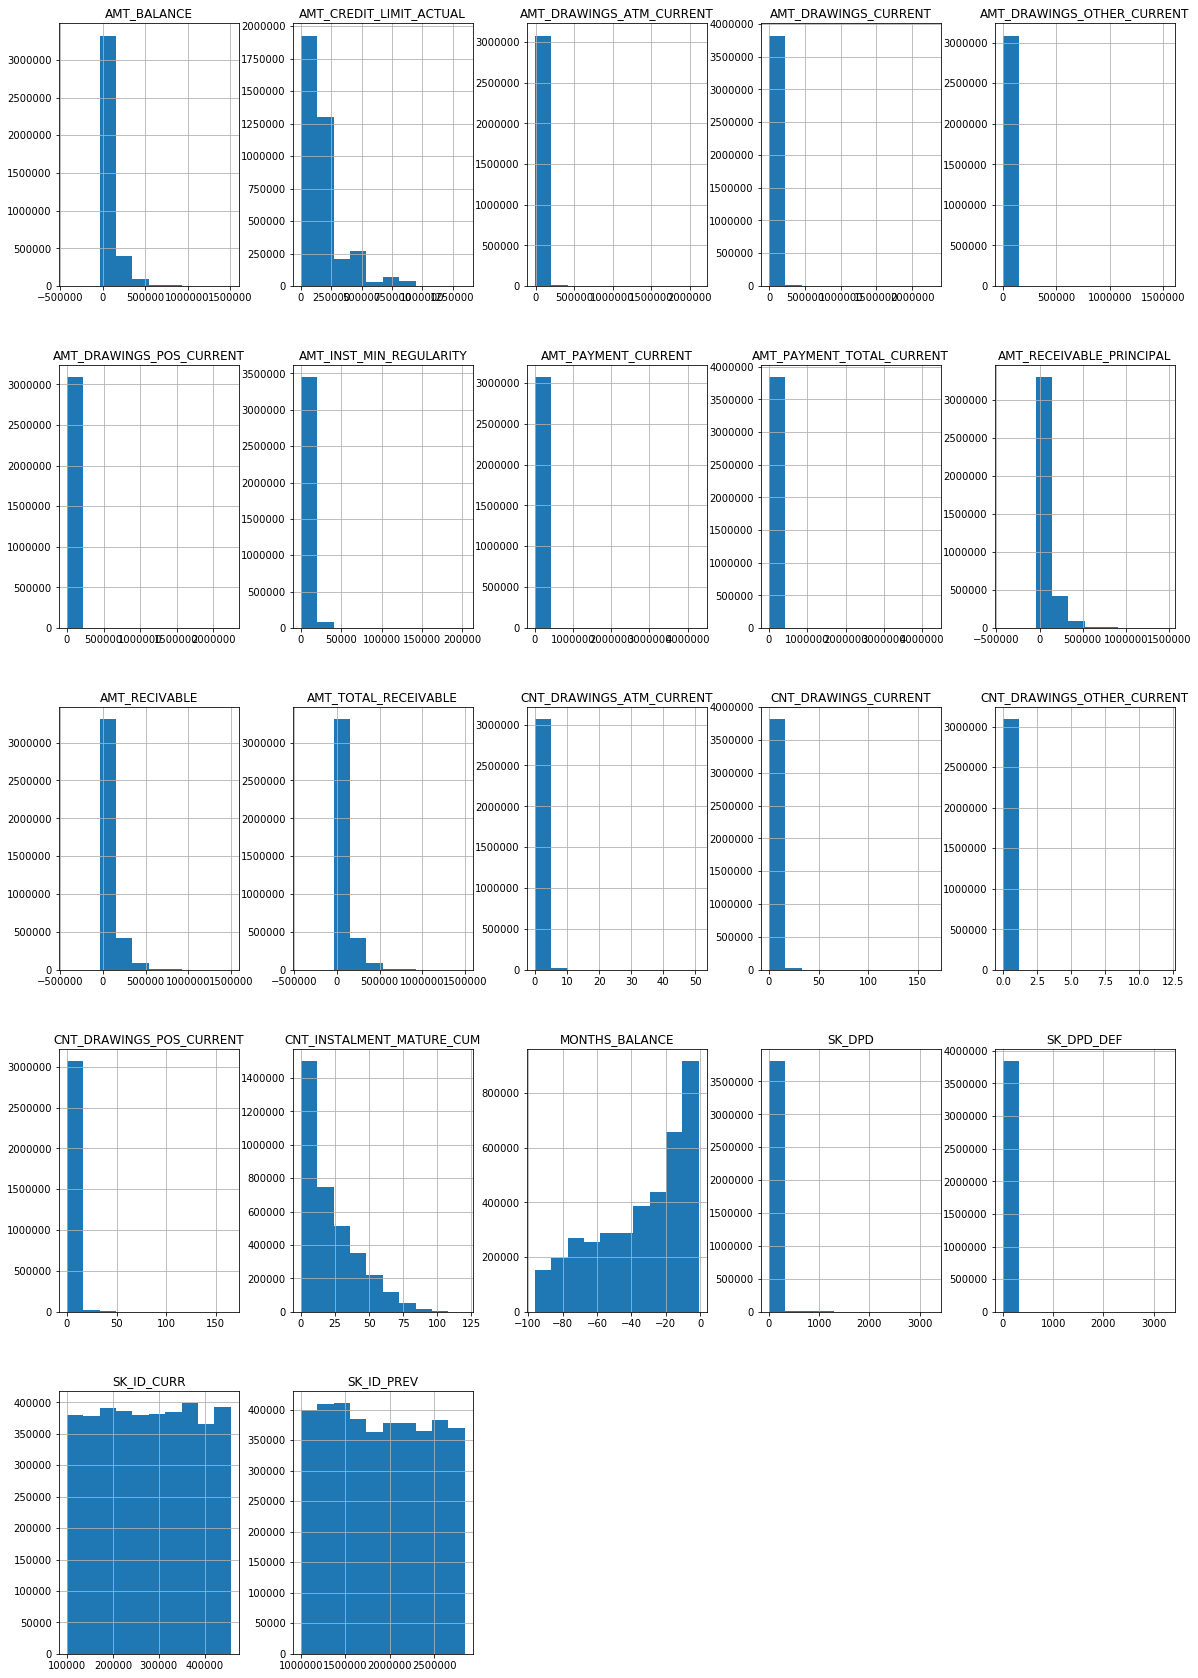

In [51]:
basic_eda(df_credit, 'credit_card_balance')

### SK_ID_PREV and SK_ID_CURR

In [52]:
print("* All records have distinct SK_ID_CURR? \t", len(df_credit['SK_ID_CURR'].unique()) == df_credit.shape[0])
print("* Total number of unique SK_ID_CURR   : \t", len(df_credit['SK_ID_CURR'].unique()))
print("* All records have distinct SK_ID_PREV? \t", len(df_credit['SK_ID_PREV'].unique()) == df_credit.shape[0])
print("* Total number of unique SK_ID_PREV   : \t", len(df_credit['SK_ID_PREV'].unique()))

* All records have distinct SK_ID_CURR? 	 False
* Total number of unique SK_ID_CURR   : 	 103558
* All records have distinct SK_ID_PREV? 	 False
* Total number of unique SK_ID_PREV   : 	 104307


### SK_DPD and SK_DPD_DEF

In [53]:
print("* Values of SK_DPD\n")
# display(df_credit['SK_DPD'].value_counts())
display(df_credit['SK_DPD'].groupby(pd.cut(df_credit['SK_DPD'],[0,100,200,500,1000,2000,5000])).count())

print("* Values of SK_DPD_DEF\n")
# display(df_credit['SK_DPD_DEF'].value_counts())
display(df_credit['SK_DPD_DEF'].groupby(pd.cut(df_credit['SK_DPD_DEF'],[0,100,200,500,1000,2000,5000])).count())

* Values of SK_DPD



SK_DPD
(0, 100]        106769
(100, 200]        4915
(200, 500]       12673
(500, 1000]      15095
(1000, 2000]     13447
(2000, 5000]       456
Name: SK_DPD, dtype: int64

* Values of SK_DPD_DEF



SK_DPD_DEF
(0, 100]        88307
(100, 200]        113
(200, 500]        172
(500, 1000]       240
(1000, 2000]      354
(2000, 5000]      154
Name: SK_DPD_DEF, dtype: int64

Text(0.5, 1.0, 'Distribution of SK_DPD_DEF')

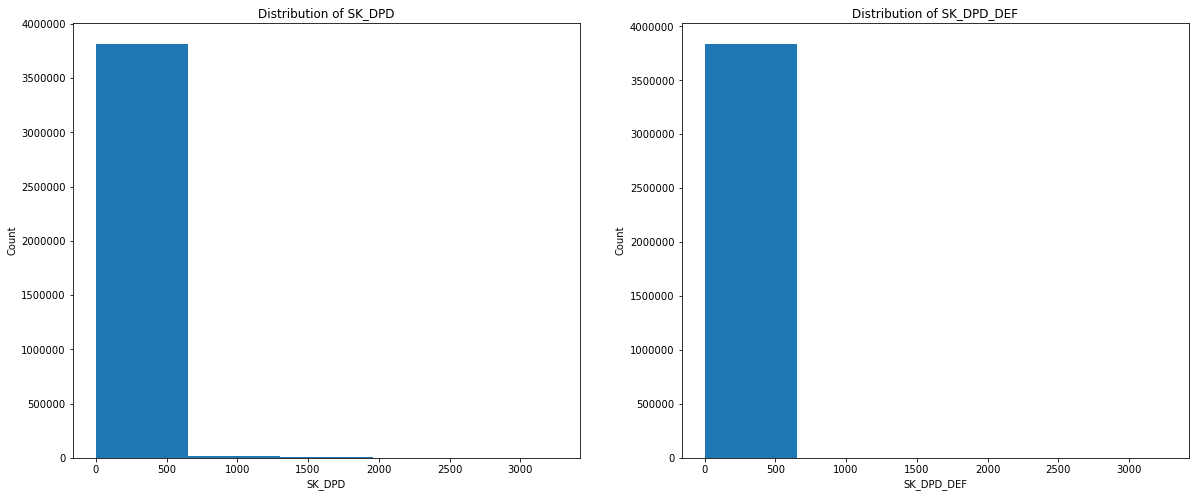

In [54]:
plt.figure(figsize=(20,8))
plt.subplot(121)
_ = plt.hist(df_credit['SK_DPD'], bins=5)
plt.xlabel("SK_DPD")
plt.ylabel("Count")
plt.title("Distribution of SK_DPD")
plt.subplot(122)
_ = plt.hist(df_credit['SK_DPD_DEF'], bins=5)
plt.xlabel("SK_DPD_DEF")
plt.ylabel("Count")
plt.title("Distribution of SK_DPD_DEF")

In [55]:
print(f"* SK_DPD and SK_DPD_DEF are different for {len(df_credit[df_credit.SK_DPD != df_credit.SK_DPD_DEF])} records")
# We will use the the SK_PDP for evaluating how many DPD (Days past due) during the month on the previous credit since the amount is larger

* SK_DPD and SK_DPD_DEF are different for 64439 records


### NAME_CONTRACT_STATUS

In [56]:
df_credit['NAME_CONTRACT_STATUS'].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

Text(0.5, 1.0, 'Distribution of the previous loan statuses')

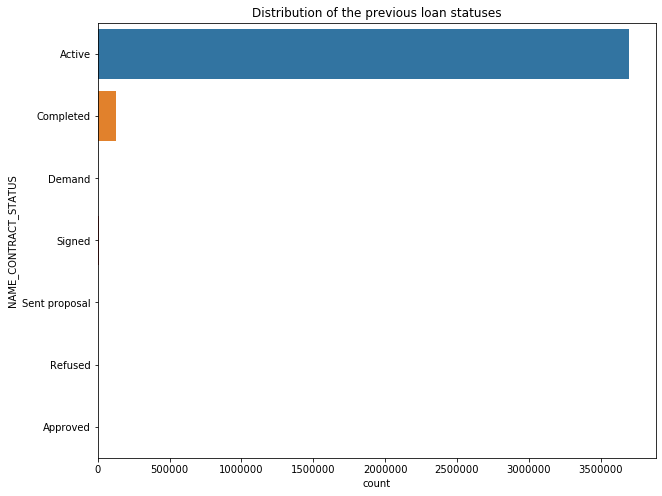

In [57]:
plt.figure(figsize=(10,8))
sns.countplot(y='NAME_CONTRACT_STATUS', data=df_credit)
plt.title("Distribution of the previous loan statuses")

## Dataset: installments_payments


************************** installments_payments ******************************

Performing basic EDA on installments_payments dataset

* The dataset has 13605401 rows and 8 columns.

* First 10 rows of the dataset:



,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375
6,2234264,184693,4.0,11,-349.0,-352.0,29432.295,29432.295
7,1818599,111420,2.0,4,-968.0,-994.0,17862.165,17862.165
8,2723183,112102,0.0,14,-197.0,-197.0,70.740,70.740
9,1413990,109741,1.0,4,-570.0,-609.0,14308.470,14308.470



* Describing the dataset statistics:



,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06



* Fetching info of the dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


None


* Check data distribution: 


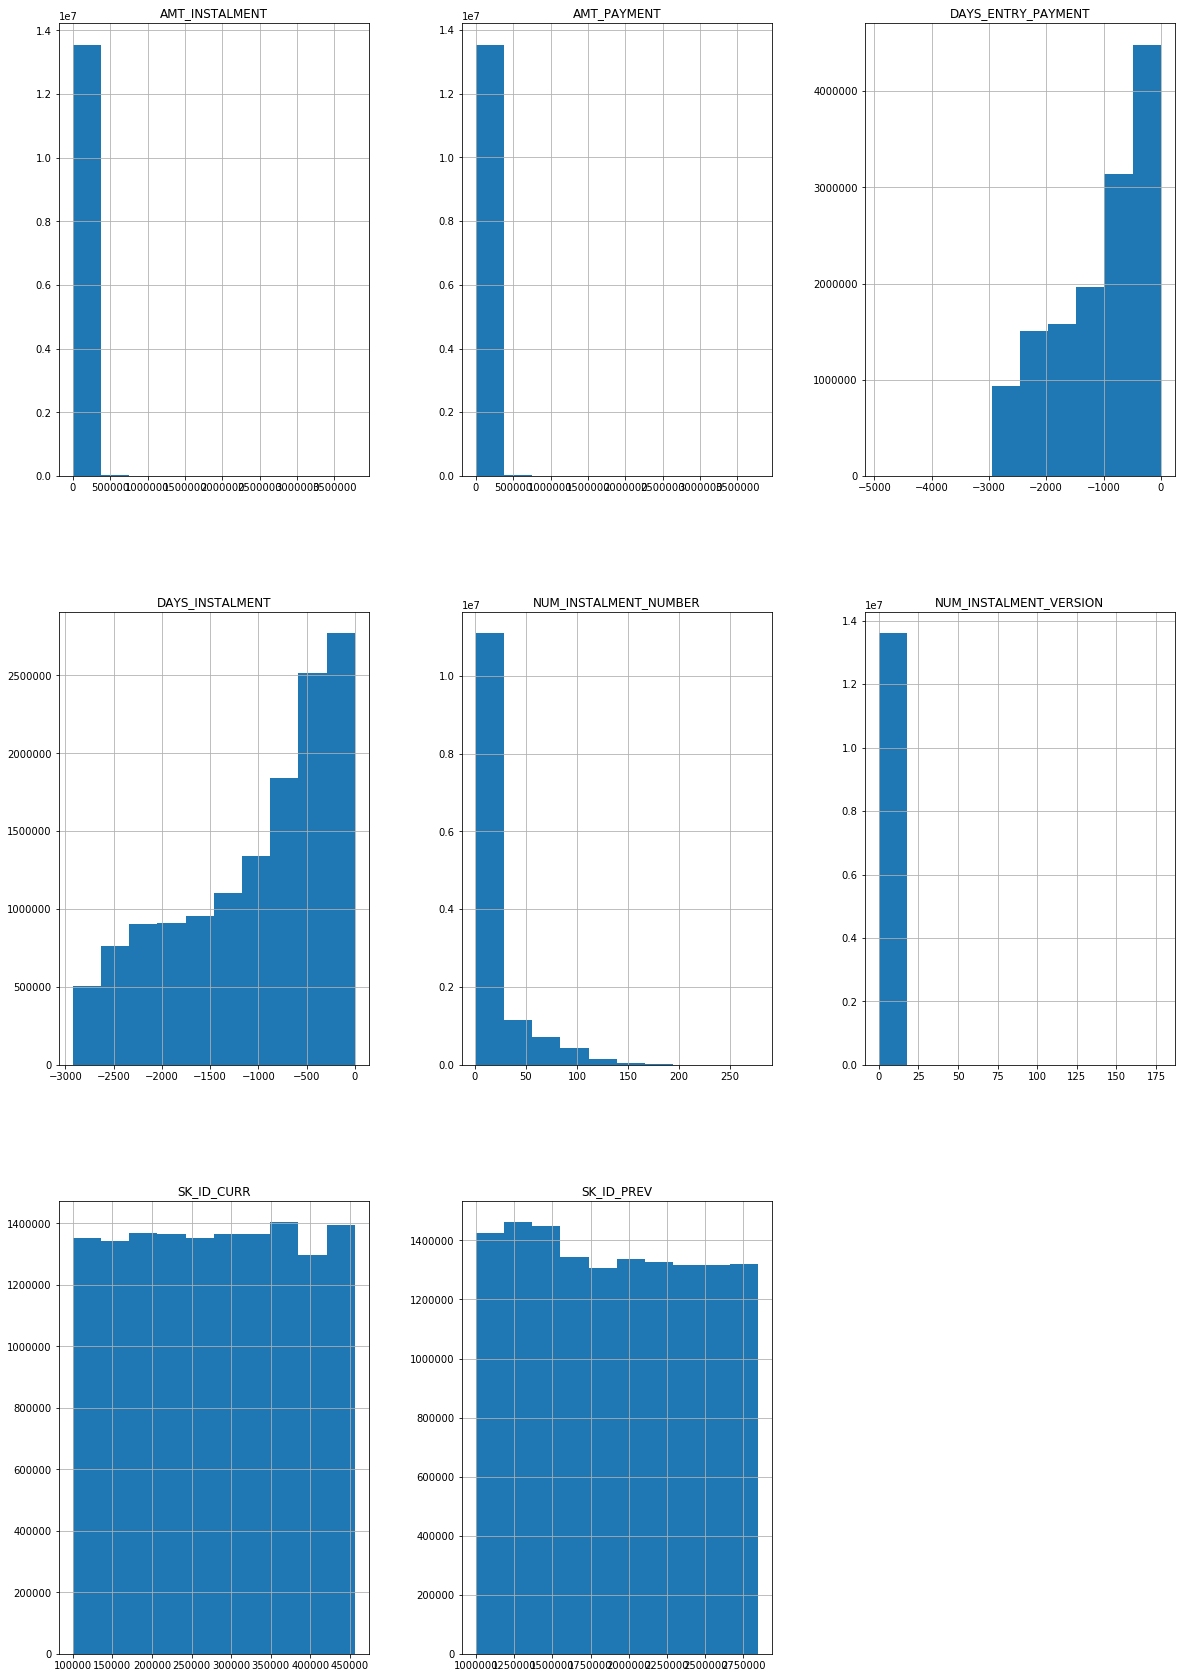

In [58]:
df_installments = datasets['installments_payments']
basic_eda(df_installments, 'installments_payments')

### SK_ID_PREV and SK_ID_CURR

In [59]:
print("* All records have distinct SK_ID_CURR? \t", len(df_installments['SK_ID_CURR'].unique()) == df_installments.shape[0])
print("* Total number of unique SK_ID_CURR   : \t", len(df_installments['SK_ID_CURR'].unique()))
print("* All records have distinct SK_ID_PREV? \t", len(df_installments['SK_ID_PREV'].unique()) == df_installments.shape[0])
print("* Total number of unique SK_ID_PREV   : \t", len(df_installments['SK_ID_PREV'].unique()))

* All records have distinct SK_ID_CURR? 	 False
* Total number of unique SK_ID_CURR   : 	 339587
* All records have distinct SK_ID_PREV? 	 False
* Total number of unique SK_ID_PREV   : 	 997752


# Feature engineering

## New features planned

* Application_train (and test)
    - Debt to income ratio
    - Number of flag documents provided
    - Income per family member
    - Excess of the loan amount over the price of the underlying goods

* POS_CASH_balance
    - How many installments are not yet paid (CNT_INSTALMENT_FUTURE) 
    - Total number of previous loans
    - Total number of previous loans per status
    - Min and max terms of previous loans  
  
* credit_card_balance
    - Average Monthly Balance per previous loans
    - Average Credit Card Limit per previous loans
    - Average Monthly Payments per previous loans
    - The percentage of over due payments per previous loans  
    
* installments_payments    
    - Payment_Days_over_installments
    - Payment_Amount_over_installments
    
* bureau & bureau_balance
    - Total overdue debt
    - Total debt
    - Number of active loans
    - Percent of debt attributed to credit cards
    - Percent of months with on-time payments 

### Dictionary for additional datasets

In [60]:
final_ds_names = ("bureau_final","credit_card_balance_final","installments_payments_final",
            "previous_application_final","POS_CASH_balance_final")

final_ds = dict()

## Dataset: application_train

### Loan amounts

In [61]:
# Create a feature to see if the loan amount is larger than the value of the underlying goods
app_train['EXCESS_LOAN'] = app_train['AMT_CREDIT'] - app_train['AMT_GOODS_PRICE']
# app_train[app_train['EXCESS_LOAN'] < 0] = 0            # replaces all columns by 0
# app_train['EXCESS_LOAN'][app_train['EXCESS_LOAN'] < 0] = 0    # replaces all columns by 0

app_train['EXCESS_LOAN'].mask(app_train['EXCESS_LOAN']<0, 0, inplace=True)

# app_train.describe
# display(app_train.describe())

### Flag doucments

In [62]:
# Create a feature to count how many of the flag documents were submitted

In [63]:
flag_docs = ['SK_ID_CURR']
for cols in app_train.columns:
    if cols[0:8] == 'FLAG_DOC':
        flag_docs.append(cols)
        
flag_df = app_train[flag_docs]
flag_pivot = flag_df.melt(id_vars = 'SK_ID_CURR', var_name = 'Document', value_name = "FLAG_DOCS_SUBMITTED")
flag_counts = flag_pivot.groupby('SK_ID_CURR').sum()
flag_counts.head()

,FLAG_DOCS_SUBMITTED
SK_ID_CURR,
100002,1
100003,1
100004,0
100006,1
100007,1


In [64]:
app_train_final = pd.merge(app_train, flag_counts, 'left', 'SK_ID_CURR')

### Income features

In [65]:
# Create a feature to measure income per family member (maybe high income isn't as good with a large family)

In [66]:
app_train_final['INCOME_PER_FAMILY_MEMBER'] = app_train_final['AMT_INCOME_TOTAL']/app_train_final['CNT_FAM_MEMBERS']

### Monthly debt/income

In [67]:
# Create a feature to measure monthly debt/income

In [68]:
app_train_final['DEBT_TO_INCOME'] = app_train_final['AMT_ANNUITY'] / (app_train_final['AMT_INCOME_TOTAL'] / 12)

### ADDITIONAL FEATURES ADDED ON PHASE 3

### AMT_CREDIT/AMT_ANNUITY

In [69]:
app_train_final['AMT_CREDIT/AMT_ANNUITY'] = app_train_final['AMT_CREDIT'] / app_train_final['AMT_ANNUITY'] 

### AMT_CREDIT - AMT_GOODS_PRICE

In [70]:
app_train_final['AMT_CREDIT - AMT_GOODS_PRICE'] = app_train_final['AMT_CREDIT'] - app_train_final['AMT_GOODS_PRICE'] 

### app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY

In [71]:
app_train_final['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = app_train_final['AMT_INCOME_TOTAL'] / 12. - app_train_final['AMT_ANNUITY']

### DAYS_EMPLOYED / DAYS_BIRTH

In [72]:
# how much work experience compare to his age
app_train_final['DAYS_EMPLOYED / DAYS_BIRTH'] = app_train_final['DAYS_EMPLOYED']/app_train_final['DAYS_BIRTH']

### EXT_SOURCE_MEAN

In [73]:
# the average of all 3 types of Normalized score from external data sources.
app_train_final['EXT_SOURCE_MEAN'] = (app_train_final['EXT_SOURCE_1'] + app_train_final['EXT_SOURCE_2'] + app_train_final['EXT_SOURCE_3'])/3

In [586]:
### EXT_SOURCE_MORE

In [590]:
# Since EXT_SOURCE has been on my top feature imortance, we want to try the combination of them as well shown below:

app_train_final['EXT_SOURCE_STD']=app_train_final[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
app_train_final['app EXT_SOURCE prod'] = app_train_final['EXT_SOURCE_1'] * app_train_final['EXT_SOURCE_2'] * app_train_final['EXT_SOURCE_3']
app_train_final['app EXT_SOURCE_1 * EXT_SOURCE_2'] = app_train_final['EXT_SOURCE_1'] * app_train_final['EXT_SOURCE_2']
app_train_final['app EXT_SOURCE_1 * EXT_SOURCE_3'] = app_train_final['EXT_SOURCE_1'] * app_train_final['EXT_SOURCE_3']
app_train_final['app EXT_SOURCE_2 * EXT_SOURCE_3'] = app_train_final['EXT_SOURCE_2'] * app_train_final['EXT_SOURCE_3']

### Higher Education

In [591]:
# how much people get higher education, if it is shown as one, otherwise show 0

from collections import Counter
Counter(app_train_final['NAME_EDUCATION_TYPE'])

Counter({'Secondary / secondary special': 218391,
         'Higher education': 74863,
         'Incomplete higher': 10277,
         'Lower secondary': 3816,
         'Academic degree': 164})

In [592]:
app_train_final['NAME_EDUCATION_TYPE_higher_education'] = app_train_final['NAME_EDUCATION_TYPE'].map(lambda x: 1 if x=='Higher education' else 0)                                     

In [593]:
app_train_final['NAME_EDUCATION_TYPE_higher_education']

0         0
1         1
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    1
307509    0
307510    1
Name: NAME_EDUCATION_TYPE_higher_education, Length: 307511, dtype: int64

In [594]:
app_train_final.shape

(307511, 137)

In [595]:
# app_train_final.columns.tolist()

In [596]:
## Show final dataframe after adding additional features

app_train_final.head(15)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_CREDIT - AMT_GOODS_PRICE,app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY,DAYS_EMPLOYED / DAYS_BIRTH,EXT_SOURCE_MEAN,NAME_EDUCATION_TYPE_higher_education,EXT_SOURCE_STD,app EXT_SOURCE prod,app EXT_SOURCE_1 * EXT_SOURCE_2,app EXT_SOURCE_1 * EXT_SOURCE_3,app EXT_SOURCE_2 * EXT_SOURCE_3
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,55597.5,-7825.50000,-0.067329,0.161787,0,0.092026,0.003043,0.021834,0.011573,0.036649
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,...,164002.5,-13198.50000,-0.070862,NaN,1,0.219895,NaN,0.193685,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,...,0.0,-1125.00000,-0.011814,NaN,0,0.122792,NaN,NaN,NaN,0.405575
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,...,15682.5,-18436.50000,-0.159905,NaN,0,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,...,0.0,-11740.50000,-0.152418,NaN,0,NaN,NaN,NaN,NaN,NaN
5,100008,0,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,...,35995.5,-19267.50000,-0.093737,NaN,0,0.188799,NaN,NaN,NaN,0.220054
6,100009,0,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,...,165726.0,-27051.00000,-0.227174,0.663607,1,0.150717,0.276010,0.560927,0.381229,0.356251
7,100010,0,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,...,0.0,-12075.00000,-0.023820,NaN,1,0.122771,NaN,NaN,NaN,0.386178
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,106110.0,-24451.50000,NaN,0.514935,0,0.280096,0.090840,0.120842,0.441513,0.154665
9,100012,0,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,...,0.0,-9000.00000,-0.139540,NaN,0,NaN,NaN,NaN,NaN,NaN


## Dataset: Application_Test

We will duplicate the new features created for the Train data for the test data as well

In [597]:
# app_test = datasets['application_test']

app_test['EXCESS_LOAN'] = app_test['AMT_CREDIT'] - app_test['AMT_GOODS_PRICE']
app_test['EXCESS_LOAN'].mask(app_test['EXCESS_LOAN']<0, 0, inplace=True)
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXCESS_LOAN
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,118800.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,42768.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,33264.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [598]:
flag_docs = ['SK_ID_CURR']
for cols in app_test.columns:
    if cols[0:8] == 'FLAG_DOC':
        flag_docs.append(cols)
        
flag_df = app_test[flag_docs]
flag_pivot = flag_df.melt(id_vars = 'SK_ID_CURR', var_name = 'Document', value_name = "FLAG_DOCS_SUBMITTED")
flag_counts = flag_pivot.groupby('SK_ID_CURR').sum()
flag_counts.head()

,FLAG_DOCS_SUBMITTED
SK_ID_CURR,
100001,1
100005,1
100013,1
100028,1
100038,1


In [599]:
app_test_final = pd.merge(app_test, flag_counts, 'left', 'SK_ID_CURR')

In [600]:
app_test_final['INCOME_PER_FAMILY_MEMBER'] = app_test_final['AMT_INCOME_TOTAL']/app_test_final['CNT_FAM_MEMBERS']

In [601]:
app_test_final['DEBT_TO_INCOME'] = app_test_final['AMT_ANNUITY'] / (app_test_final['AMT_INCOME_TOTAL'] / 12)

### ADDITIONAL FEATURES ADDED ON PHASE 3

### AMT_CREDIT/AMT_ANNUITY

In [602]:
app_test_final['AMT_CREDIT/AMT_ANNUITY'] = app_test_final['AMT_CREDIT'] / app_test_final['AMT_ANNUITY'] 

### AMT_CREDIT - AMT_GOODS_PRICE

In [603]:
app_test_final['AMT_CREDIT - AMT_GOODS_PRICE'] = app_test_final['AMT_CREDIT'] - app_test_final['AMT_GOODS_PRICE'] 

### app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY

In [604]:
app_test_final['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = app_test_final['AMT_INCOME_TOTAL'] / 12. - app_test_final['AMT_ANNUITY']

### DAYS_EMPLOYED / DAYS_BIRTH

In [605]:
app_test_final['DAYS_EMPLOYED / DAYS_BIRTH'] = app_test_final['DAYS_EMPLOYED']/app_test_final['DAYS_BIRTH']

### EXT_SOURCE_MEAN

In [606]:
app_test_final['EXT_SOURCE_MEAN'] = (app_test_final['EXT_SOURCE_1'] + app_test_final['EXT_SOURCE_2'] + app_test_final['EXT_SOURCE_3'])/3

### EXT_SOURCE_MORE

In [607]:
# Since EXT_SOURCE has been on my top feature imortance, we want to try the combination of them as well shown below:

app_test_final['EXT_SOURCE_STD']=app_test_final[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
app_test_final['app EXT_SOURCE prod'] = app_test_final['EXT_SOURCE_1'] * app_test_final['EXT_SOURCE_2'] * app_train_final['EXT_SOURCE_3']
app_test_final['app EXT_SOURCE_1 * EXT_SOURCE_2'] = app_test_final['EXT_SOURCE_1'] * app_test_final['EXT_SOURCE_2']
app_test_final['app EXT_SOURCE_1 * EXT_SOURCE_3'] = app_test_final['EXT_SOURCE_1'] * app_test_final['EXT_SOURCE_3']
app_test_final['app EXT_SOURCE_2 * EXT_SOURCE_3'] = app_test_final['EXT_SOURCE_2'] * app_test_final['EXT_SOURCE_3']

### higher education

In [608]:
app_test_final['NAME_EDUCATION_TYPE_higher_education'] = app_test_final['NAME_EDUCATION_TYPE'].map(lambda x: 1 if x=='Higher education' else 0)                                     

In [609]:
app_test_final.shape

(48744, 136)

In [610]:
# app_test_final.columns.tolist()

In [611]:
## Show final dataframe after adding additional features

app_test_final.head(15)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_CREDIT - AMT_GOODS_PRICE,app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY,DAYS_EMPLOYED / DAYS_BIRTH,EXT_SOURCE_MEAN,EXT_SOURCE_STD,app EXT_SOURCE prod,app EXT_SOURCE_1 * EXT_SOURCE_2,app EXT_SOURCE_1 * EXT_SOURCE_3,app EXT_SOURCE_2 * EXT_SOURCE_3,NAME_EDUCATION_TYPE_higher_education
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,118800.0,-9310.5,0.121044,0.567263,0.353601,0.082832,0.594305,0.120057,0.125965,1
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,42768.0,-9120.0,0.247398,0.429869,0.136694,NaN,0.164783,0.244619,0.126276,0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,33264.0,-52902.0,0.222477,NaN,0.062788,NaN,NaN,NaN,0.427564,1
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,-22768.5,0.133515,0.549372,0.055432,NaN,0.267955,0.322119,0.312281,0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0.0,-17067.0,0.168021,NaN,0.158068,NaN,0.086051,NaN,NaN,0
5,100042,Cash loans,F,Y,Y,0,270000.0,959688.0,34600.5,810000.0,...,149688.0,-12100.5,0.645506,NaN,0.166969,NaN,NaN,NaN,0.247017,0
6,100057,Cash loans,M,Y,Y,2,180000.0,499221.0,22117.5,373500.0,...,125721.0,-7117.5,0.154630,0.661065,0.095263,0.213805,0.434510,0.495512,0.371924,1
7,100065,Cash loans,M,N,Y,0,166500.0,180000.0,14220.0,180000.0,...,0.0,-345.0,0.145755,0.496896,0.161581,0.187359,0.346541,0.176577,0.191490,1
8,100066,Cash loans,F,N,Y,0,315000.0,364896.0,28957.5,315000.0,...,49896.0,-2707.5,0.079488,0.683331,0.146253,0.436842,0.581120,0.375562,0.422751,1
9,100067,Cash loans,F,Y,Y,1,162000.0,45000.0,5337.0,45000.0,...,0.0,8163.0,0.252525,0.283159,0.140269,NaN,0.093668,0.040863,0.086331,1


## Dataset: POS_CASH_balance

### OHE on categorical features 

In [90]:
# OHE on latest value of NAME_CONTRACT_STATUS

In [91]:
df_pos_cash_latest_status = df_pos_cash_latest[['SK_ID_PREV','SK_ID_CURR','NAME_CONTRACT_STATUS']]
df_pos_cash_latest_status.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_STATUS
45995,1000001,158271,Completed
2792302,1000002,101962,Completed
7085917,1000003,252457,Active
4078063,1000004,260094,Completed
7852623,1000005,176456,Completed


In [92]:
df_dummies = pd.get_dummies(df_pos_cash_latest_status['NAME_CONTRACT_STATUS'])
df_dummies.head()

,Active,Amortized debt,Approved,Canceled,Completed,Demand,Returned to the store,Signed
45995,0,0,0,0,1,0,0,0
2792302,0,0,0,0,1,0,0,0
7085917,1,0,0,0,0,0,0,0
4078063,0,0,0,0,1,0,0,0
7852623,0,0,0,0,1,0,0,0


In [93]:
df_pos_cash_latest_status = pd.concat([df_pos_cash_latest_status,df_dummies] , axis=1, sort=False)
df_pos_cash_latest_status.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_STATUS,Active,Amortized debt,Approved,Canceled,Completed,Demand,Returned to the store,Signed
45995,1000001,158271,Completed,0,0,0,0,1,0,0,0
2792302,1000002,101962,Completed,0,0,0,0,1,0,0,0
7085917,1000003,252457,Active,1,0,0,0,0,0,0,0
4078063,1000004,260094,Completed,0,0,0,0,1,0,0,0
7852623,1000005,176456,Completed,0,0,0,0,1,0,0,0


### Group by 'SK_ID_CURR' and 'SK_ID_PREV'

In [94]:
d = {
    'SK_ID_PREV':['size'],
    'CNT_INSTALMENT_FUTURE':['min'],
    'CNT_INSTALMENT':['max']
    
}
df_agg = df_pos_cash.groupby(['SK_ID_CURR', 'SK_ID_PREV']).agg(d)
# display(df_agg.head())

df_agg.columns = df_agg.columns.droplevel()
# display(df_agg.head())
df_agg.reset_index(inplace=True)
# display(df_agg.head())
df_agg.columns=['SK_ID_CURR','SK_ID_PREV','Count','Remaining_repays','Initial_term']
display(df_agg.head())

,SK_ID_CURR,SK_ID_PREV,Count,Remaining_repays,Initial_term
0,100001,1369693,5,0.0,4.0
1,100001,1851984,4,0.0,4.0
2,100002,1038818,19,6.0,24.0
3,100003,1810518,8,0.0,12.0
4,100003,2396755,12,1.0,12.0


### Add current statuses

In [95]:
df_final = pd.merge(df_agg,df_pos_cash_latest_status,how='left')

In [96]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936325 entries, 0 to 936324
Data columns (total 14 columns):
SK_ID_CURR               936325 non-null int64
SK_ID_PREV               936325 non-null int64
Count                    936325 non-null int64
Remaining_repays         935435 non-null float64
Initial_term             935435 non-null float64
NAME_CONTRACT_STATUS     936325 non-null object
Active                   936325 non-null uint8
Amortized debt           936325 non-null uint8
Approved                 936325 non-null uint8
Canceled                 936325 non-null uint8
Completed                936325 non-null uint8
Demand                   936325 non-null uint8
Returned to the store    936325 non-null uint8
Signed                   936325 non-null uint8
dtypes: float64(2), int64(3), object(1), uint8(8)
memory usage: 57.1+ MB


In [97]:
df_final.head()

,SK_ID_CURR,SK_ID_PREV,Count,Remaining_repays,Initial_term,NAME_CONTRACT_STATUS,Active,Amortized debt,Approved,Canceled,Completed,Demand,Returned to the store,Signed
0,100001,1369693,5,0.0,4.0,Completed,0,0,0,0,1,0,0,0
1,100001,1851984,4,0.0,4.0,Completed,0,0,0,0,1,0,0,0
2,100002,1038818,19,6.0,24.0,Active,1,0,0,0,0,0,0,0
3,100003,1810518,8,0.0,12.0,Completed,0,0,0,0,1,0,0,0
4,100003,2396755,12,1.0,12.0,Active,1,0,0,0,0,0,0,0


### Group by SK_ID_CURR

In [98]:
d2 = {
    'SK_ID_PREV':['size'],
    'Remaining_repays':['sum'],
    'Initial_term':  ['min','max'],
    'Active':        ['sum'],
    'Amortized debt':['sum'],
    'Approved':      ['sum'],
    'Canceled':      ['sum'],
    'Completed':     ['sum'],
    'Demand':        ['sum'],
    'Returned to the store':['sum'],
    'Signed':        ['sum']
}
df_out = df_final.groupby('SK_ID_CURR').agg(d2)

# display(df_out.head())

df_out.columns = df_out.columns.droplevel()

df_out.reset_index(inplace=True)

df_out.columns=['SK_ID_CURR','Count','Total_Remaining_repays','Min_Initial_term','Max_Initial_term','Active','Amortized debt','Approved','Canceled','Completed','Demand','Returned to the store','Signed']
display(df_out.head())

,SK_ID_CURR,Count,Total_Remaining_repays,Min_Initial_term,Max_Initial_term,Active,Amortized debt,Approved,Canceled,Completed,Demand,Returned to the store,Signed
0,100001,2,0.0,4.0,4.0,0,0,0,0,2,0,0,0
1,100002,1,6.0,24.0,24.0,1,0,0,0,0,0,0,0
2,100003,3,1.0,6.0,12.0,1,0,0,0,2,0,0,0
3,100004,1,0.0,4.0,4.0,0,0,0,0,1,0,0,0
4,100005,1,0.0,12.0,12.0,0,0,0,0,1,0,0,0


In [99]:
final_ds['POS_CASH_balance_final'] = df_out

## Dataset: previous_application

In [100]:
# cat_features = ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION', 'NFLAG_INSURED_ON_APPROVAL']
# working with selected features for now

cat_features = ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START','NAME_CONTRACT_STATUS']


### OHE on categorical features 

In [101]:
df_prev_app_new_cat = df_prev_app_new[cat_features]

imputed = SimpleImputer(fill_value='missing', strategy='constant').fit_transform(df_prev_app_new_cat) 

ohe = OneHotEncoder().fit(imputed)
cat = pd.DataFrame(ohe.transform(imputed).toarray(
            ), index=df_prev_app_new_cat.index, columns=list(ohe.get_feature_names(cat_features)))

cat.columns=['Cashloans', 'Consumerloans', 'Revolvingloans', 'XNA', 'FRIDAY', 'MONDAY', 'SATURDAY', 'SUNDAY', 'THURSDAY', 'TUESDAY', 'WEDNESDAY', 'Approved', 'Canceled', 'Refused', 'Unusedoffer']
cat.head()

,Cashloans,Consumerloans,Revolvingloans,XNA,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,Approved,Canceled,Refused,Unusedoffer
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [102]:
df_prev_app_new= pd.concat([df_prev_app_new,cat], axis=1)

### Aggreagate each type of loans

In [103]:
d = {
 'Cashloans'     : ['sum'],
 'Consumerloans' : ['sum'],
 'Revolvingloans': ['sum'],
 'XNA'            : ['sum'],
 'FRIDAY'         : ['sum'],
 'MONDAY'         : ['sum'],
 'SATURDAY'       : ['sum'],
 'SUNDAY'         : ['sum'],
 'THURSDAY'       : ['sum'],
 'TUESDAY'        : ['sum'],
 'WEDNESDAY'      : ['sum'],
 'Approved'       : ['sum'],
 'Canceled'       : ['sum'],
 'Refused'        : ['sum'],
 'Unusedoffer'   : ['sum'],
 'SK_ID_PREV'                 : ['size'],
 'AMT_ANNUITY'                : ['min','max','mean'],
 'AMT_APPLICATION'            : ['min','max','mean'],
 'DAYS_DECISION'              : ['min','max','mean'],
}


df_out = df_prev_app_new.groupby(by='SK_ID_CURR').agg(d)

df_out.columns = df_out.columns.droplevel()

df_out.reset_index(inplace=True)

df_out.columns= ['SK_ID_CURR','Cash loans', 'Consumer loans', 'Revolvingloans', 'XNA', 'FRIDAY', 'MONDAY', 'SATURDAY', 'SUNDAY', 'THURSDAY', 'TUESDAY', 'WEDNESDAY', 'Approved', 'Canceled', 'Refused', 'Unusedoffer', 'Total_records', 'Tot_AMT_ANNUITY_min', 'Tot_AMT_ANNUITY_max', 'Tot_AMT_ANNUITY_mean', 'Tot_AMT_APPLICATION_min', 'Tot_AMT_APPLICATION_max', 'Tot_AMT_APPLICATION_mean', 'DAYS_DECISION_min', 'DAYS_DECISION_max', 'DAYS_DECISION_mean']
display(df_out.head())

,SK_ID_CURR,Cash loans,Consumer loans,Revolvingloans,XNA,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,...,Total_records,Tot_AMT_ANNUITY_min,Tot_AMT_ANNUITY_max,Tot_AMT_ANNUITY_mean,Tot_AMT_APPLICATION_min,Tot_AMT_APPLICATION_max,Tot_AMT_APPLICATION_mean,DAYS_DECISION_min,DAYS_DECISION_max,DAYS_DECISION_mean
0,100001,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,3951.000,3951.000,3951.000,24835.5,24835.5,24835.50,-1740,-1740,-1740.0
1,100002,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,9251.775,9251.775,9251.775,179055.0,179055.0,179055.00,-606,-606,-606.0
2,100003,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,3,6737.310,98356.995,56553.990,68809.5,900000.0,435436.50,-2341,-746,-1305.0
3,100004,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,5357.250,5357.250,5357.250,24282.0,24282.0,24282.00,-815,-815,-815.0
4,100005,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2,4813.200,4813.200,4813.200,0.0,44617.5,22308.75,-757,-315,-536.0


In [104]:
# df_prev_app_new.columns

In [105]:
final_ds['previous_application_final'] = df_out

## Dataset: Bureau and Bureau_balance

### Feature Engineering

In [106]:
# Avg_installment_days_difference and Avg_installment_amount_difference
# Let's start with the bureau balance dataset first

bb_df = datasets['bureau_balance']

### Late Payments

In [107]:
## We are going to focus on the number of months that had a late payment

tot_month_counts = bb_df.groupby('SK_ID_BUREAU').count()['STATUS']
late_month_counts = bb_df[(bb_df['STATUS'] != '0') & (bb_df['STATUS'] != 'C') & (bb_df['STATUS'] != 'X')].groupby('SK_ID_BUREAU').count()['STATUS']
status_df = pd.merge(left = tot_month_counts, right = late_month_counts, how = 'left', on = "SK_ID_BUREAU", suffixes = ('_tot', '_late'))

status_df.fillna(0, inplace = True)
status_df.head()

,STATUS_tot,STATUS_late
SK_ID_BUREAU,,
5001709,97,0.0
5001710,83,0.0
5001711,4,0.0
5001712,19,0.0
5001713,22,0.0


In [108]:
## Now let's work on the bureau dataset

bureau_df = datasets['bureau']
bureau_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


### Pick out just the credit card data

In [109]:
## Pick out just the credit card data

cc_debt_df = bureau_df[bureau_df['CREDIT_TYPE'] == 'Credit card']
cc_debt_df.drop(cc_debt_df.columns.difference(['SK_ID_CURR','CREDIT_TYPE', 'AMT_CREDIT_SUM_DEBT']), 1, inplace=True)
cc_debt_df = cc_debt_df.groupby('SK_ID_CURR').sum()
cc_debt_df.rename({'SK_ID_CURR': 'SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT': 'CREDIT_CARD_DEBT'}, axis = 1, inplace = True)
cc_debt_df.head()

,CREDIT_CARD_DEBT
SK_ID_CURR,
100002,0.0
100003,0.0
100005,0.0
100009,326628.0
100011,0.0


### Count how many active loans 

In [110]:
## Count how many active loans the applicant has when they are applying for the Home Credit loan

active_df = bureau_df[bureau_df['CREDIT_ACTIVE'] == 'Active']
active_df.drop(active_df.columns.difference(['SK_ID_CURR','CREDIT_ACTIVE']), 1, inplace=True)
active_df = active_df.groupby('SK_ID_CURR').count()
active_df.rename({'SK_ID_CURR': 'SK_ID_CURR', 'CREDIT_ACTIVE': 'TOTAL_ACTIVE_LOANS'}, axis = 1, inplace = True)
active_df.head()

,TOTAL_ACTIVE_LOANS
SK_ID_CURR,
100001,3
100002,2
100003,1
100005,2
100008,1


In [111]:
bureau_df.drop(bureau_df.columns.difference(['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM_DEBT', 'SK_ID_BUREAU']), 1, inplace=True)

In [112]:
## combine the bureau dataset with the late payment info from bureau_balance dataset

combined_bureau_df = pd.merge(bureau_df, status_df, 'left','SK_ID_BUREAU')

In [113]:
combined_bureau_df.drop('SK_ID_BUREAU', inplace = True, axis = 1)

In [114]:
combined_bureau_df = combined_bureau_df.groupby('SK_ID_CURR').sum()

### Combine the datasets

In [115]:
## combine the other features created from the bureau dataset

bureau_final = pd.merge(combined_bureau_df, active_df, 'left', 'SK_ID_CURR')
bureau_final = pd.merge(bureau_final, cc_debt_df, 'left', 'SK_ID_CURR')

In [116]:
## transform/combine several features into new ones

bureau_final['Percent_Late'] = bureau_final['STATUS_late']/bureau_final['STATUS_tot']
bureau_final['PERCENT_CREDIT_CARD'] = bureau_final['CREDIT_CARD_DEBT']/bureau_final['AMT_CREDIT_SUM_DEBT']

In [117]:
bureau_final.drop(['STATUS_tot', 'STATUS_late', 'CREDIT_CARD_DEBT'], axis = 1, inplace = True)

In [118]:
## Make the columns headers more descriptive

bureau_final.rename({'AMT_CREDIT_SUM_DEBT': 'TOTAL_DEBT', 'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_DEBT_OVERDUE', 'TOTAL_ACTIVE_LOANS': 'TOTAL_NUMBER_OF_ACTIVE_LOANS', 'Percent_Late': 'PERCENT_LATE'}, axis = 1, inplace = True)
bureau_final.head()

,TOTAL_DEBT,TOTAL_DEBT_OVERDUE,TOTAL_NUMBER_OF_ACTIVE_LOANS,PERCENT_LATE,PERCENT_CREDIT_CARD
SK_ID_CURR,,,,,
100001,596686.5,0.0,3.0,0.005814,NaN
100002,245781.0,0.0,2.0,0.245455,0.0
100003,0.0,0.0,1.0,NaN,NaN
100004,0.0,0.0,NaN,NaN,NaN
100005,568408.5,0.0,2.0,0.000000,0.0


In [119]:
## fill in Null values for two of the features

bureau_final['PERCENT_CREDIT_CARD'] = bureau_final['PERCENT_CREDIT_CARD'].fillna(0)
bureau_final['TOTAL_NUMBER_OF_ACTIVE_LOANS'] = bureau_final['TOTAL_NUMBER_OF_ACTIVE_LOANS'].fillna(0)
bureau_final.head()

,TOTAL_DEBT,TOTAL_DEBT_OVERDUE,TOTAL_NUMBER_OF_ACTIVE_LOANS,PERCENT_LATE,PERCENT_CREDIT_CARD
SK_ID_CURR,,,,,
100001,596686.5,0.0,3.0,0.005814,0.0
100002,245781.0,0.0,2.0,0.245455,0.0
100003,0.0,0.0,1.0,NaN,0.0
100004,0.0,0.0,0.0,NaN,0.0
100005,568408.5,0.0,2.0,0.000000,0.0


In [120]:
final_ds['bureau_final'] = bureau_final

## Dataset: installments_payments

### Create new features

In [121]:
# create new features Avg_installment_days_difference and Avg_installment_amount_difference

In [122]:
df_installments['installment_days_difference']=df_installments['DAYS_ENTRY_PAYMENT']-df_installments['DAYS_INSTALMENT']
df_installments['installment_amount_difference']=df_installments['AMT_PAYMENT']-df_installments['AMT_INSTALMENT']

df_installments['payment_over_installment_ratio']=df_installments['AMT_PAYMENT']/df_installments['AMT_INSTALMENT'].mean()
df_installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,installment_days_difference,installment_amount_difference,payment_over_installment_ratio
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,-7.0,0.000,0.407507
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,0.0,0.000,0.100671
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,0.0,0.000,1.491123
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,-8.0,0.000,1.428084
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,17.0,-4.455,0.126714


### ADDTIONAL FEATURES ADDED IN PHASE 3

### INS_DAYS_ENTRY_PAYMENT_MAX

In [349]:
d = {
    'installment_days_difference':['mean'],
    'installment_amount_difference':['mean'],
#     ADDTIONAL FEATURES ADDED IN PHASE 3
    'DAYS_ENTRY_PAYMENT':['max'],
    'payment_over_installment_ratio': ['mean'],
    'AMT_PAYMENT': ['sum'],
    
    
}
df_ins_agg = df_installments.groupby(['SK_ID_CURR', 'SK_ID_PREV']).agg(d)
# display(df_ins_agg.head())

df_ins_agg.columns = df_ins_agg.columns.droplevel()
# display(df_ins_agg.head())
df_ins_agg.reset_index(inplace=True)
# display(df_ins_agg.head())
df_ins_agg.columns=['SK_ID_CURR','SK_ID_PREV','Avg_installment_days_difference', 'Avg_installment_amount_difference', 'INS_DAYS_ENTRY_PAYMENT_MAX', 'payment_over_installment_ratio', 'INS_AMT_PAYMENT_SUM']
display(df_ins_agg.head())

,SK_ID_CURR,SK_ID_PREV,Avg_installment_days_difference,Avg_installment_amount_difference,INS_DAYS_ENTRY_PAYMENT_MAX,payment_over_installment_ratio,INS_AMT_PAYMENT_SUM
0,100001,1369693,-15.500000,0.0,-1628.0,0.428876,29250.900
1,100001,1851984,3.666667,0.0,-2856.0,0.233517,11945.025
2,100002,1038818,-20.421053,0.0,-49.0,0.677926,219625.695
3,100003,1810518,-4.428571,0.0,-544.0,9.643202,1150977.330
4,100003,2396755,-6.750000,0.0,-1985.0,0.394766,80773.380


### Group by SK_ID_CURR

In [350]:
d2 = {
    'Avg_installment_days_difference':['mean'],
    'Avg_installment_amount_difference':['mean'],
    'INS_DAYS_ENTRY_PAYMENT_MAX':['max'],
    'payment_over_installment_ratio': ['mean'],
    'INS_AMT_PAYMENT_SUM': ['sum']
}
df_ins_out = df_ins_agg.groupby('SK_ID_CURR').agg(d2)

# display(df_ins_out.head())

df_ins_out.columns = df_ins_out.columns.droplevel()

df_ins_out.reset_index(inplace=True)

df_ins_out.columns=['SK_ID_CURR','Avg_installment_days_difference', 'Avg_installment_amount_difference', 'INS_DAYS_ENTRY_PAYMENT_MAX', 'payment_over_installment_ratio', 'INS_AMT_PAYMENT_SUM']
display(df_ins_out.head())

,SK_ID_CURR,Avg_installment_days_difference,Avg_installment_amount_difference,INS_DAYS_ENTRY_PAYMENT_MAX,payment_over_installment_ratio,INS_AMT_PAYMENT_SUM
0,100001,-5.916667,0.0,-1628.0,0.331196,41195.925
1,100002,-20.421053,0.0,-49.0,0.677926,219625.695
2,100003,-7.448413,0.0,-544.0,4.607290,1618864.650
3,100004,-7.666667,0.0,-727.0,0.416175,21288.465
4,100005,-23.555556,0.0,-470.0,0.365975,56161.845


In [351]:
final_ds['installments_payments_final'] = df_ins_out

## Dataset: credit_card_balance

### Percentage of Late Pyaments

In [126]:
df_credit.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [127]:
tot_month_counts = df_credit.groupby('SK_ID_PREV').count()['MONTHS_BALANCE']
late_month_counts = df_credit[(df_credit['SK_DPD'] != 0)].groupby('SK_ID_PREV').count()['SK_DPD']
df_credit_late = pd.merge(left = tot_month_counts, right = late_month_counts, how = 'left', on = "SK_ID_PREV")

df_credit_late.fillna(0, inplace = True)
df_credit_late.head()

,MONTHS_BALANCE,SK_DPD
SK_ID_PREV,,
1000018,5,0.0
1000030,8,0.0
1000031,16,0.0
1000035,5,0.0
1000077,11,0.0


In [128]:
df_credit_late['Payment_Pass_Due_Perc'] = df_credit_late['SK_DPD']/df_credit_late['MONTHS_BALANCE']
df_credit_late.head()

,MONTHS_BALANCE,SK_DPD,Payment_Pass_Due_Perc
SK_ID_PREV,,,
1000018,5,0.0,0.0
1000030,8,0.0,0.0
1000031,16,0.0,0.0
1000035,5,0.0,0.0
1000077,11,0.0,0.0


In [129]:
d = {
    'AMT_BALANCE':['mean'],
    'AMT_CREDIT_LIMIT_ACTUAL':['mean'],
    'AMT_PAYMENT_TOTAL_CURRENT':['mean'],
    'SK_ID_CURR': ['count'],

    
}
df_credit_agg = df_credit.groupby(['SK_ID_CURR','SK_ID_PREV']).agg(d)


df_credit_agg.columns = df_credit_agg.columns.droplevel()

df_credit_agg.reset_index(inplace=True)

df_credit_agg.columns=['SK_ID_CURR', 'SK_ID_PREV','CC_Average_Monthly_Balance','CC_Average_Credit_Card_Limit', 'CC_Average_Monthly_Payments', 'CC_Credit_Cards_Count']
display(df_credit_agg.head())

,SK_ID_CURR,SK_ID_PREV,CC_Average_Monthly_Balance,CC_Average_Credit_Card_Limit,CC_Average_Monthly_Payments,CC_Credit_Cards_Count
0,100006,1489396,0.000000,270000.000000,0.000000,6
1,100011,1843384,54482.111149,164189.189189,4520.067568,74
2,100013,2038692,18159.919219,131718.750000,6817.172344,96
3,100021,2594025,0.000000,675000.000000,0.000000,17
4,100023,1499902,0.000000,135000.000000,0.000000,8


In [130]:
combined_credit_df = pd.merge(df_credit_agg, df_credit_late, 'left','SK_ID_PREV')
#combined_credit_df.head()
dropped_credit_df=combined_credit_df.drop(columns=['MONTHS_BALANCE', 'SK_DPD'])
dropped_credit_df.head()

,SK_ID_CURR,SK_ID_PREV,CC_Average_Monthly_Balance,CC_Average_Credit_Card_Limit,CC_Average_Monthly_Payments,CC_Credit_Cards_Count,Payment_Pass_Due_Perc
0,100006,1489396,0.000000,270000.000000,0.000000,6,0.000000
1,100011,1843384,54482.111149,164189.189189,4520.067568,74,0.000000
2,100013,2038692,18159.919219,131718.750000,6817.172344,96,0.010417
3,100021,2594025,0.000000,675000.000000,0.000000,17,0.000000
4,100023,1499902,0.000000,135000.000000,0.000000,8,0.000000


### Group by SK_ID_CURR

In [131]:
d2 = {
    'CC_Average_Monthly_Balance':['sum'],
    'CC_Average_Credit_Card_Limit':['mean'],
    'CC_Average_Monthly_Payments':['sum'],
    'Payment_Pass_Due_Perc': ['mean'],
    'CC_Credit_Cards_Count': ['sum'],
    
}
df_credit_out = dropped_credit_df.groupby('SK_ID_CURR').agg(d2)

# display(df_out.head())

df_credit_out.columns = df_credit_out.columns.droplevel()

df_credit_out.reset_index(inplace=True)

df_credit_out.columns=['SK_ID_CURR','CC_Average_Monthly_Balance','CC_Average_Credit_Card_Limit', 'CC_Average_Monthly_Payments', 'CC_Average_percentage_pass_due', 'CC_Credit_Cards_Count']
display(df_credit_out.head(10))

,SK_ID_CURR,CC_Average_Monthly_Balance,CC_Average_Credit_Card_Limit,CC_Average_Monthly_Payments,CC_Average_percentage_pass_due,CC_Credit_Cards_Count
0,100006,0.000000,270000.000000,0.000000,0.000000,6
1,100011,54482.111149,164189.189189,4520.067568,0.000000,74
2,100013,18159.919219,131718.750000,6817.172344,0.010417,96
3,100021,0.000000,675000.000000,0.000000,0.000000,17
4,100023,0.000000,135000.000000,0.000000,0.000000,8
5,100028,8085.058163,225000.000000,5606.152347,0.000000,49
6,100036,0.000000,78750.000000,0.000000,0.000000,12
7,100042,33356.183036,78750.000000,7369.821429,0.023810,84
8,100043,208572.600000,287045.454545,13441.831364,0.000000,33
9,100047,0.000000,326250.000000,0.000000,0.000000,36


In [132]:
final_ds['credit_card_balance_final'] = df_credit_out

## Final Engineered Datasets

In [612]:
for i in final_ds.keys():
    print(i, " shape: ", final_ds[i].shape)

POS_CASH_balance_final  shape:  (337252, 13)
previous_application_final  shape:  (338857, 26)
bureau_final  shape:  (305811, 5)
installments_payments_final  shape:  (339587, 6)
credit_card_balance_final  shape:  (103558, 6)


In [134]:
# save files into a pickle file to save running time
# import pickle 
# with open('final_datasets.pickle', 'wb') as f:
#     pickle.dump(final_ds, f, protocol=pickle.HIGHEST_PROTOCOL)

In [135]:
# import pickle 
# load datasets from a pickle file
# with open('final_datasets.pickle', 'rb') as f:
#     final_ds = pickle.load(f)

# HCDR preprocessing

## Select highly correlated features

In [353]:
correlations = app_train.corr()['TARGET'].sort_values()

In [137]:
num_of_features = 100

In [613]:
# del selected_features
# del selected_features_phase_3

In [614]:
# +1 in tail() so that TARGET is not considered in num_of_features
selected_features = list(correlations.tail(num_of_features//2 + 1).index) + list(correlations.head(num_of_features//2).index)
selected_features.remove('TARGET')

# We don't have any categorical features in the highly correlated features. Hence we selected these 7 categorical features manually
categoricals = ['CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE']

selected_features = selected_features + categoricals
print()
print("Selected features= ", selected_features)


Selected features=  ['FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'AMT_INCOME_TOTAL', 'FLAG_DOCUMENT_17', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'FLAG_DOCUMENT_4', 'SK_ID_CURR', 'AMT_REQ_CREDIT_BUREAU_QRT', 'FLAG_EMAIL', 'NONLIVINGAPARTMENTS_MODE', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_20', 'FLAG_CONT_MOBILE', 'FLAG_MOBIL', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'LIVE_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_2', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_WORK_PHONE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY', 'EXCESS_LOAN', 'OWN_CAR_AGE', 'DAYS_REGISTRATION', 'FLAG_DOCUMENT_3', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_EMP_

In [615]:
print(len(selected_features))
selected_features.remove('SK_ID_CURR')
print(len(selected_features))

107
106


In [616]:
# Split the provided training data into training and validation. Not creating test dataset as test dataset is separate

from sklearn.model_selection import train_test_split

use_application_data_ONLY = False #use joined data
if use_application_data_ONLY:
    # just selected a few features for a baseline experiment
#     selected_features = ['AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1',
#         'EXT_SOURCE_2','EXT_SOURCE_3','CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE', 
#                    'NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE']
    
    X_train = datasets["application_train"][selected_features]
    y_train = datasets["application_train"]['TARGET']
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
    X_kaggle_test= datasets["application_test"][selected_features]
else:
    X_train = datasets["application_train"][selected_features]
    y_train = datasets["application_train"]['TARGET']
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15,  random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
    X_kaggle_test= datasets["application_test"][selected_features]

print(f"X train           shape: {X_train.shape}")
print(f"Y train           shape: {y_train.shape}")
print()
print(f"X validation      shape: {X_valid.shape}")
print(f"Y validation      shape: {y_valid.shape}")
print()
print(f"X test            shape: {X_test.shape}")
print(f"Y test            shape: {y_test.shape}")
print()
print(f"X X_kaggle_test   shape: {X_kaggle_test.shape}")
print(f"Y X_kaggle_test is not available as the test dataset is from a Kaggel competition")


X train           shape: (222176, 106)
Y train           shape: (222176,)

X validation      shape: (46127, 106)
Y validation      shape: (46127,)

X test            shape: (39208, 106)
Y test            shape: (39208,)

X X_kaggle_test   shape: (48744, 106)
Y X_kaggle_test is not available as the test dataset is from a Kaggel competition


## Pipeline creation

In [617]:
# Class from the starter notebook
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
# class DataFrameSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, attribute_names):
#         self.attribute_names = attribute_names
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         return X[self.attribute_names].values

In [618]:
# seperate the featured into numerical and catagorical for pipelines

num_attribs = list(X_train.select_dtypes(exclude='object').columns)
cat_attribs = list(X_train.select_dtypes(include='object').columns)

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

data_prep_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])          

In [619]:
print('Number of numberical features:', len(num_attribs))
print('Number of categorical features:', len(cat_attribs))

Number of numberical features: 99
Number of categorical features: 7


# Baseline Logistic Model

To get a baseline, we will use some of the features after being preprocessed through the pipeline.
The baseline model is a logistic regression model

In [361]:
def pct(x):
    return round(100*x,3)

## Create expLog

In [375]:
try:
    expLog
except NameError:
    expLog = pd.DataFrame(columns=["exp_name", 
                                   "Train Acc", 
                                   "Valid Acc",
                                   "Test  Acc",
                                   "Train AUC", 
                                   "Valid AUC",
                                   "Test  AUC",
                                   "Train Time"
                                  ])


In [376]:
from time import time
start = time()

full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("linear", LogisticRegression())
    ])


model_0 = full_pipeline_with_predictor.fit(X_train, y_train)
train_time = np.round(time() - start, 4)

In [377]:
from sklearn.metrics import accuracy_score

np.round(accuracy_score(y_train, model_0.predict(X_train)), 3)

0.92

In [378]:
from sklearn.metrics import accuracy_score, roc_auc_score

exp_name = f"Baseline_{len(selected_features)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model_0.predict(X_train)), 
                accuracy_score(y_valid, model_0.predict(X_valid)),
                accuracy_score(y_test, model_0.predict(X_test)), 
                roc_auc_score(y_train, model_0.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model_0.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model_0.predict_proba(X_test)[:, 1]),
                train_time
                ],4)) 

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train Time
0,Baseline_106_features,0.9198,0.9192,0.9159,0.7466,0.7445,0.7497,10.0434


# Merge additional datasets

In [149]:
# Phase 0 and 1: We use our original data set datasets["application_train"] to train

# # Merge additional datasetswith X_train, y_train, X_val, y_val
# print(datasets["application_train"].head())
# selected_features = ['SK_ID_CURR','TARGET'] + selected_features
# df_train_selected = datasets["application_train"][selected_features]


# selected_features.remove('TARGET')
# df_test_selected  = datasets["application_test"][selected_features]
# # df_train_selected.columns

## Phase 3: features added to Train and Test

In [620]:
app_train_final.shape

(307511, 137)

In [621]:
datasets["application_train"].shape

(307511, 124)

In [632]:
print(len(selected_features))

106


In [633]:
# Phase 3: We use 'app_train_final' to train as our training set as we have added new features on the training and testing sets

# print(app_train_final.head())
selected_features_phase_3 = ['SK_ID_CURR','TARGET'] + selected_features + ['EXCESS_LOAN',
                                         'FLAG_DOCS_SUBMITTED',
                                         'INCOME_PER_FAMILY_MEMBER',
                                         'DEBT_TO_INCOME',
                                         'AMT_CREDIT/AMT_ANNUITY',
                                         'AMT_CREDIT - AMT_GOODS_PRICE',
                                         'app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY',
                                         'DAYS_EMPLOYED / DAYS_BIRTH',
                                        'EXT_SOURCE_MEAN',
                                        'EXT_SOURCE_STD',
                                        'app EXT_SOURCE prod',
                                        'app EXT_SOURCE_1 * EXT_SOURCE_2',
                                        'app EXT_SOURCE_1 * EXT_SOURCE_3'   ,
                                        'app EXT_SOURCE_2 * EXT_SOURCE_3',
                                        'NAME_EDUCATION_TYPE_higher_education',
                                                                          
                                                                          ]
print(selected_features_phase_3)
print(len(selected_features_phase_3))


['SK_ID_CURR', 'TARGET', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'AMT_INCOME_TOTAL', 'FLAG_DOCUMENT_17', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'FLAG_DOCUMENT_4', 'AMT_REQ_CREDIT_BUREAU_QRT', 'FLAG_EMAIL', 'NONLIVINGAPARTMENTS_MODE', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_20', 'FLAG_CONT_MOBILE', 'FLAG_MOBIL', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'LIVE_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_2', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_WORK_PHONE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY', 'EXCESS_LOAN', 'OWN_CAR_AGE', 'DAYS_REGISTRATION', 'FLAG_DOCUMENT_3', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_EMP_PHONE', 'RE

In [634]:
print(len(selected_features_phase_3))

count=selected_features_phase_3.count('EXCESS_LOAN')
print(count)

123
2


In [635]:
set([x for x in selected_features_phase_3 if selected_features_phase_3.count(x)>1])


{'EXCESS_LOAN'}

In [636]:
# top 100 correlated features already inclued feature "EXCESS_LOAN", so we remove it here
selected_features_phase_3.remove('EXCESS_LOAN')
print(len(selected_features_phase_3))

122


In [637]:
df_train_selected = app_train_final[selected_features_phase_3]
selected_features_phase_3.remove('TARGET')

#same features selected for the testing set
df_test_selected  = app_test_final[selected_features_phase_3]


In [638]:
print("Train: ", df_train_selected.shape)
print("Test: ",  df_test_selected.shape)

Train:  (307511, 122)
Test:  (48744, 121)


In [639]:
# Merge all 6 additional datasets to the training and testing sets

def merge_additional(df):
    df = pd.merge(df, final_ds['POS_CASH_balance_final'][['SK_ID_CURR','Count','Total_Remaining_repays','Max_Initial_term']], 
                         'left', on='SK_ID_CURR')
    print("Merged POS_CASH_balance: ",  df.shape)

    df = pd.merge(df, final_ds['bureau_final'], 'left',  on='SK_ID_CURR')
    print("Merged bureau: ",  df.shape)

    df = pd.merge(df, final_ds['installments_payments_final'], 'left', on='SK_ID_CURR')
    print("Merged installments_payments: ",  df.shape)
    
    df = pd.merge(df, final_ds['previous_application_final'], 'left', on='SK_ID_CURR')
    print("Merged previous_application_final: ",  df.shape)
    
    df = pd.merge(df, final_ds['credit_card_balance_final'], 'left', on='SK_ID_CURR')
    print("Merged credit_card_balance_final: ",  df.shape)
    
    return df

In [640]:
df_train_selected = merge_additional(df_train_selected)
df_test_selected = merge_additional(df_test_selected)

Merged POS_CASH_balance:  (307511, 125)
Merged bureau:  (307511, 130)
Merged installments_payments:  (307511, 135)
Merged previous_application_final:  (307511, 160)
Merged credit_card_balance_final:  (307511, 165)
Merged POS_CASH_balance:  (48744, 124)
Merged bureau:  (48744, 129)
Merged installments_payments:  (48744, 134)
Merged previous_application_final:  (48744, 159)
Merged credit_card_balance_final:  (48744, 164)


In [641]:
print("Train: ", df_train_selected.shape)
print("Test: ",  df_test_selected.shape)

Train:  (307511, 165)
Test:  (48744, 164)


## Phase 3: features added to 6 Additional Datasets

In [642]:
selected_features_phase_3.remove('SK_ID_CURR')
selected_features_phase_3 = selected_features_phase_3 + [ 
                                         'Count',  'Total_Remaining_repays',  'TOTAL_DEBT',  'Max_Initial_term',
                                         'TOTAL_DEBT_OVERDUE',  'TOTAL_NUMBER_OF_ACTIVE_LOANS',  'PERCENT_LATE',  
                                         'PERCENT_CREDIT_CARD',  
    
    
                                         'Avg_installment_days_difference',  
                                         'Avg_installment_amount_difference',
                                         'INS_DAYS_ENTRY_PAYMENT_MAX',
                                         'payment_over_installment_ratio',
                                         'INS_AMT_PAYMENT_SUM',
    
                                         'Cash loans', 'Consumer loans', 'Revolvingloans', 'XNA', 'FRIDAY', 'MONDAY', 'SATURDAY', 'SUNDAY', 
                                         'THURSDAY', 'TUESDAY', 'WEDNESDAY', 'Approved', 'Canceled', 'Refused', 'Unusedoffer', 'Total_records', 
                                         'Tot_AMT_ANNUITY_min', 'Tot_AMT_ANNUITY_max', 'Tot_AMT_ANNUITY_mean', 'Tot_AMT_APPLICATION_min', 
                                         'Tot_AMT_APPLICATION_max', 'Tot_AMT_APPLICATION_mean', 'DAYS_DECISION_min', 'DAYS_DECISION_max', 
                                         'DAYS_DECISION_mean', 
                                         'CC_Average_Monthly_Balance',
                                         'CC_Average_Credit_Card_Limit',
                                         'CC_Average_Monthly_Payments',
                                         'CC_Average_percentage_pass_due',
                                         'CC_Credit_Cards_Count'

]

print(len(selected_features_phase_3))

163


In [643]:
count=selected_features_phase_3.count('EXCESS_LOAN')
print(count)

1


In [644]:
print(df_train_selected.shape)
print(df_test_selected.shape)

(307511, 165)
(48744, 164)


In [645]:
X_train = df_train_selected
y_train = df_train_selected['TARGET']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15,  random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_kaggle_test= df_test_selected[selected_features_phase_3]

print(f"X train           shape: {X_train.shape}")
print(f"Y train           shape: {y_train.shape}")
print()
print(f"X validation      shape: {X_valid.shape}")
print(f"Y validation      shape: {y_valid.shape}")
print()
print(f"X test            shape: {X_test.shape}")
print(f"Y test            shape: {y_test.shape}")
print()
print(f"X X_kaggle_test   shape: {X_kaggle_test.shape}")
print(f"Y X_kaggle_test is not available as the test dataset is from a Kaggel competition")

X train           shape: (222176, 163)
Y train           shape: (222176,)

X validation      shape: (46127, 163)
Y validation      shape: (46127,)

X test            shape: (39208, 163)
Y test            shape: (39208,)

X X_kaggle_test   shape: (48744, 163)
Y X_kaggle_test is not available as the test dataset is from a Kaggel competition


In [646]:
# new_cols = list()
# for i in final_ds.keys():
# #     print(final_ds[i].columns)
#     new_cols += list(final_ds[i].columns)
# new_cols

In [647]:
X_train.head()

,FLAG_DOCUMENT_18,FLAG_DOCUMENT_15,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,AMT_INCOME_TOTAL,FLAG_DOCUMENT_17,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,FLAG_DOCUMENT_4,AMT_REQ_CREDIT_BUREAU_QRT,...,Tot_AMT_APPLICATION_max,Tot_AMT_APPLICATION_mean,DAYS_DECISION_min,DAYS_DECISION_max,DAYS_DECISION_mean,CC_Average_Monthly_Balance,CC_Average_Credit_Card_Limit,CC_Average_Monthly_Payments,CC_Average_percentage_pass_due,CC_Credit_Cards_Count
21614,0,0,0,0,180000.0,0,NaN,NaN,0,1.0,...,108261.0,108261.0,-668.0,-668.0,-668.000000,NaN,NaN,NaN,NaN,NaN
209797,0,0,0,0,81000.0,0,NaN,NaN,0,NaN,...,114030.0,114030.0,-828.0,-828.0,-828.000000,NaN,NaN,NaN,NaN,NaN
17976,0,0,0,0,90000.0,0,0.0077,0.0078,0,0.0,...,180000.0,69082.5,-1762.0,-667.0,-1187.000000,26859.835946,103378.378378,915.725676,0.0,37.0
282543,0,0,0,0,135000.0,0,NaN,NaN,0,0.0,...,68445.0,49791.0,-756.0,-636.0,-697.333333,NaN,NaN,NaN,NaN,NaN
52206,0,0,0,0,225000.0,0,0.0000,0.0000,0,0.0,...,47245.5,47245.5,-1484.0,-1484.0,-1484.000000,NaN,NaN,NaN,NaN,NaN


# Model 1: Logistic Regression

## Pipeline creation 

In [648]:
num_attribs = list(X_train.select_dtypes(exclude='object').columns)
print("Numerical Features are:")
print(num_attribs)
print("------------------------")
print('Number of numberical features: ', len(num_attribs))

Numerical Features are:
['FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'AMT_INCOME_TOTAL', 'FLAG_DOCUMENT_17', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'FLAG_DOCUMENT_4', 'AMT_REQ_CREDIT_BUREAU_QRT', 'FLAG_EMAIL', 'NONLIVINGAPARTMENTS_MODE', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_20', 'FLAG_CONT_MOBILE', 'FLAG_MOBIL', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'LIVE_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_2', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_WORK_PHONE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY', 'OWN_CAR_AGE', 'DAYS_REGISTRATION', 'FLAG_DOCUMENT_3', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_WORK

In [649]:
print("Categorical Features are:")
cat_attribs = list(X_train.select_dtypes(include='object').columns)
print(cat_attribs)
print("------------------------")
print('Number of Categorical features: ', len(cat_attribs))

Categorical Features are:
['CODE_GENDER', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE']
------------------------
Number of Categorical features:  7


In [411]:
# Logistic regression with our selected features

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

data_prep_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [412]:
# prep_X_train = data_prep_pipeline.fit_transform(X_train)
# prep_X_valid = data_prep_pipeline.fit_transform(X_valid)
# prep_X_test = data_prep_pipeline.fit_transform(X_test)


## Model execution

In [413]:
from time import time
start = time()
 
full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("linear", LogisticRegression())
    ])


model_1 = full_pipeline_with_predictor.fit(X_train, y_train)
train_time = np.round(time() - start, 4)

In [414]:
from sklearn.metrics import accuracy_score, roc_auc_score

exp_name = f"LogisticRegression_{len(selected_features_phase_3)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model_1.predict(X_train)), 
                accuracy_score(y_valid, model_1.predict(X_valid)),
                accuracy_score(y_test, model_1.predict(X_test)), 
                roc_auc_score(y_train, model_1.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model_1.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model_1.predict_proba(X_test)[:, 1]),
                train_time
                ],4)) 

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train Time
0,Baseline_106_features,0.9198,0.9192,0.9159,0.7466,0.7445,0.7497,10.0434
1,LogisticRegression_157_features,0.9198,0.9202,0.9163,0.7635,0.7618,0.7631,12.1088


## Hyperparamter Tuning with GridSearchCV

In [415]:
from sklearn.model_selection import GridSearchCV

full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("linear", LogisticRegression(verbose = 1))
    ])

param_grid = {'linear__penalty':['l1','l2', 'elasticnet'], 
              'linear__C': [1, 10, 100, 1000, 10000]
             }


start = time()
model_2 = GridSearchCV(full_pipeline_with_predictor, param_grid, cv=10, n_jobs=-1)

model_2.fit(X_train,y_train)
train_time = np.round(time() - start, 4)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s finished


In [416]:
exp_name = f"LogisticRegression_GSCV_{len(selected_features_phase_3)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model_2.predict(X_train)), 
                accuracy_score(y_valid, model_2.predict(X_valid)),
                accuracy_score(y_test, model_2.predict(X_test)), 
                roc_auc_score(y_train, model_2.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model_2.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model_2.predict_proba(X_test)[:, 1]),
                train_time
                ],4)) 

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train Time
0,Baseline_106_features,0.9198,0.9192,0.9159,0.7466,0.7445,0.7497,10.0434
1,LogisticRegression_157_features,0.9198,0.9202,0.9163,0.7635,0.7618,0.7631,12.1088
2,LogisticRegression_GSCV_157_features,0.9198,0.9203,0.9163,0.7635,0.7617,0.7631,240.5439


# Model 2: Random Forest Regression

## Random Forest without CV

In [417]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=20, n_jobs=-1, random_state=42)

start = time()

# %%time 
full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("random_forest", rnd_clf)
    ])


model_3 = full_pipeline_with_predictor.fit(X_train, y_train)

train_time = np.round(time() - start, 4)

In [418]:
from sklearn.metrics import accuracy_score, roc_auc_score

exp_name = f"RamdomForest_{len(selected_features_phase_3)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model_3.predict(X_train)), 
                accuracy_score(y_valid, model_3.predict(X_valid)),
                accuracy_score(y_test, model_3.predict(X_test)), 
                roc_auc_score(y_train, model_3.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model_3.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model_3.predict_proba(X_test)[:, 1]),
                train_time
                ],4)) 

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train Time
0,Baseline_106_features,0.9198,0.9192,0.9159,0.7466,0.7445,0.7497,10.0434
1,LogisticRegression_157_features,0.9198,0.9202,0.9163,0.7635,0.7618,0.7631,12.1088
2,LogisticRegression_GSCV_157_features,0.9198,0.9203,0.9163,0.7635,0.7617,0.7631,240.5439
3,RamdomForest_157_features,0.9198,0.9194,0.9160,0.7523,0.7488,0.7489,58.0801


## Random Forest with CV

In [419]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from tempfile import mkdtemp
from shutil import rmtree

cachedir = mkdtemp()
start = time()

full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("RandomForest", RandomForestClassifier())  # iterations=100,learning_rate=0.03,
    ])


params = {
    'RandomForest__n_estimators': [100],
#     'RandomForest__min_samples_split': list(range(2,10)),
    'RandomForest__max_depth': [5,10,15,20],
#     'RandomForest__max_features': [5,7,9]
}


rnd_clf = RandomizedSearchCV(full_pipeline_with_predictor, params, 
#                            n_iter=15, 
                             cv = 10, 
                             scoring='roc_auc', 
                             verbose=2, 
                             n_jobs=-1)


cv_fit = rnd_clf.fit(X_train, y_train)
model_4 = cv_fit.best_estimator_
train_time = np.round(time() - start, 4)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 13.1min finished


In [420]:
exp_name = f"RamdomForestCV_{len(selected_features_phase_3)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model_4.predict(X_train)), 
                accuracy_score(y_valid, model_4.predict(X_valid)),
                accuracy_score(y_test, model_4.predict(X_test)), 
                roc_auc_score(y_train, model_4.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model_4.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model_4.predict_proba(X_test)[:, 1]),
                train_time
                ],4)) 

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train Time
0,Baseline_106_features,0.9198,0.9192,0.9159,0.7466,0.7445,0.7497,10.0434
1,LogisticRegression_157_features,0.9198,0.9202,0.9163,0.7635,0.7618,0.7631,12.1088
2,LogisticRegression_GSCV_157_features,0.9198,0.9203,0.9163,0.7635,0.7617,0.7631,240.5439
3,RamdomForest_157_features,0.9198,0.9194,0.9160,0.7523,0.7488,0.7489,58.0801
4,RamdomForestCV_157_features,0.9198,0.9194,0.9160,0.8367,0.7596,0.7594,863.3264


# Model 3: XGBoosting

## XGBoost with default settings

In [421]:
import xgboost as xgb
full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("xgboost", xgb.XGBClassifier())
    ])

start = time()
model_5 = full_pipeline_with_predictor.fit(X_train, y_train)
train_time = np.round(time() - start, 4)

In [422]:
exp_name = f"XGBoost_{len(selected_features_phase_3)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model_5.predict(X_train)), 
                accuracy_score(y_valid, model_5.predict(X_valid)),
                accuracy_score(y_test, model_5.predict(X_test)), 
                roc_auc_score(y_train, model_5.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model_5.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model_5.predict_proba(X_test)[:, 1]),
                train_time
                ],4)) 

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train Time
0,Baseline_106_features,0.9198,0.9192,0.9159,0.7466,0.7445,0.7497,10.0434
1,LogisticRegression_157_features,0.9198,0.9202,0.9163,0.7635,0.7618,0.7631,12.1088
2,LogisticRegression_GSCV_157_features,0.9198,0.9203,0.9163,0.7635,0.7617,0.7631,240.5439
3,RamdomForest_157_features,0.9198,0.9194,0.9160,0.7523,0.7488,0.7489,58.0801
4,RamdomForestCV_157_features,0.9198,0.9194,0.9160,0.8367,0.7596,0.7594,863.3264
5,XGBoost_157_features,0.9286,0.9193,0.9152,0.8845,0.7701,0.7720,72.4219


## XGBoost with CV

In [423]:
'''full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("xgboost", xgb.XGBClassifier(n_jobs= -1))
    ])

param_grid = {"xgboost__learning_rate"    : [0.05, 0.15, 0.30],
             "xgboost__max_depth"        : [3, 8, 15],
             "xgboost__gamma"            : [0.0, 0.2, 0.4]}


start = time()
model_6 = GridSearchCV(full_pipeline_with_predictor, param_grid, cv=5, n_jobs=-1)

model_6.fit(X_train,y_train)
train_time = np.round(time() - start, 4)'''

'full_pipeline_with_predictor = Pipeline([\n        ("preparation", data_prep_pipeline),\n        ("xgboost", xgb.XGBClassifier(n_jobs= -1))\n    ])\n\nparam_grid = {"xgboost__learning_rate"    : [0.05, 0.15, 0.30],\n             "xgboost__max_depth"        : [3, 8, 15],\n             "xgboost__gamma"            : [0.0, 0.2, 0.4]}\n\n\nstart = time()\nmodel_6 = GridSearchCV(full_pipeline_with_predictor, param_grid, cv=5, n_jobs=-1)\n\nmodel_6.fit(X_train,y_train)\ntrain_time = np.round(time() - start, 4)'

# Model 4: Light GBM

In [424]:
import lightgbm as lg

params = {
    'n_estimators': 1000, 'learning_rate': 0.1, 'n_jobs': -1
}

full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ('mdl',  lg.LGBMClassifier(**params))
    ])

# start = time()
lgbm_model = full_pipeline_with_predictor.fit(X_train, y_train)
# train_time = np.round(time() - start, 4)

print("LGBM accuracy score: ", np.round(accuracy_score(y_train, lgbm_model.predict(X_train)), 3))

print("LGBM roc_auc_score: ", roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]))



LGBM accuracy score:  0.944
LGBM roc_auc_score:  0.973764938480233


In [425]:
exp_name = f"LGBM_{len(selected_features_phase_3)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, lgbm_model.predict(X_train)), 
                accuracy_score(y_valid, lgbm_model.predict(X_valid)),
                accuracy_score(y_test, lgbm_model.predict(X_test)), 
                roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, lgbm_model.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, lgbm_model.predict_proba(X_test)[:, 1]),
                train_time
                ],4)) 

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train Time
0,Baseline_106_features,0.9198,0.9192,0.9159,0.7466,0.7445,0.7497,10.0434
1,LogisticRegression_157_features,0.9198,0.9202,0.9163,0.7635,0.7618,0.7631,12.1088
2,LogisticRegression_GSCV_157_features,0.9198,0.9203,0.9163,0.7635,0.7617,0.7631,240.5439
3,RamdomForest_157_features,0.9198,0.9194,0.9160,0.7523,0.7488,0.7489,58.0801
4,RamdomForestCV_157_features,0.9198,0.9194,0.9160,0.8367,0.7596,0.7594,863.3264
5,XGBoost_157_features,0.9286,0.9193,0.9152,0.8845,0.7701,0.7720,72.4219
6,LGBM_157_features,0.9443,0.9200,0.9156,0.9738,0.7732,0.7730,72.4219


# Model 5: Light GBM Advanced

In [672]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold

from scipy.stats import ranksums
from bayes_opt import BayesianOptimization

In [673]:
print(df_train_selected.shape)
print(df_test_selected.shape)

(307511, 165)
(48744, 164)


In [674]:
# combine training and testing dataset into one dataframe, so we can process them at the same time.

df = pd.concat([df_train_selected, df_test_selected], axis = 0, ignore_index = True)

In [675]:
df.shape

(356255, 165)

In [676]:
# one_hot_encoder

In [677]:
def one_hot_encoder(data, nan_as_category = True):
    original_columns = list(data.columns)
    categorical_columns = [col for col in data.columns \
                           if not pd.api.types.is_numeric_dtype(data[col].dtype)]
    for c in categorical_columns:
        if nan_as_category:
            data[c].fillna('NaN', inplace = True)
        values = list(data[c].unique())
        for v in values:
            data[str(c) + '_' + str(v)] = (data[c] == v).astype(np.uint8)
    data.drop(categorical_columns, axis = 1, inplace = True)
    return data, [c for c in data.columns if c not in original_columns]

In [678]:
one_hot_encoder(df)
df.shape

(356255, 199)

In [657]:
# Removing features not interesting for classifier
# Use GBM as a base classifier

# from lightgbm import LGBMClassifier

# base_classifier = LGBMClassifier(random_state = 0)

# def dropFeatures(data, clf):
#     train_index = data[data['TARGET'].notnull()].index
#     train_columns = data.drop('TARGET', axis = 1).columns

#     score = 1
#     new_columns = []
#     while score > .7:
#         train_columns = train_columns.drop(new_columns)
#         clf.fit(data.loc[train_index, train_columns], data.loc[train_index, 'TARGET'])
#         f_imp = pd.Series(clf.feature_importances_, index = train_columns)
#         score = roc_auc_score(data.loc[train_index, 'TARGET'], 
#                               clf.predict_proba(data.loc[train_index, train_columns])[:, 1])
#         new_columns = f_imp[f_imp > 0].index

#     data.drop(train_columns, axis = 1, inplace = True)
#     print('After removing features not interesting for classifier there are {0:d} features'.format(data.shape[1]))
#     return data

# df = dropFeatures(df, base_classifier)


After removing features not interesting for classifier there are 149 features


In [679]:
def cv_scores(df, num_folds, params, stratified = False, verbose = -1, 
              save_train_prediction = False, train_prediction_file_name = 'train_prediction.csv',
              save_test_prediction = True, test_prediction_file_name = 'test_prediction.csv'):
    warnings.simplefilter('ignore')
    
    clf = LGBMClassifier(**params)

    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 1001)
    else:
        folds = KFold(n_splits = num_folds, shuffle = True, random_state = 1001)
        
    # Create arrays and dataframes to store results
    train_pred = np.zeros(train_df.shape[0])
    train_pred_proba = np.zeros(train_df.shape[0])

    test_pred = np.zeros(train_df.shape[0])
    test_pred_proba = np.zeros(train_df.shape[0])
    
    prediction = np.zeros(test_df.shape[0])
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    df_feature_importance = pd.DataFrame(index = feats)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print('Fold', n_fold, 'started at', time.ctime())
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = verbose, early_stopping_rounds = 200)

        train_pred[train_idx] = clf.predict(train_x, num_iteration = clf.best_iteration_)
        train_pred_proba[train_idx] = clf.predict_proba(train_x, num_iteration = clf.best_iteration_)[:, 1]
        test_pred[valid_idx] = clf.predict(valid_x, num_iteration = clf.best_iteration_)
        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        prediction += \
                clf.predict_proba(test_df[feats], num_iteration = clf.best_iteration_)[:, 1] / folds.n_splits

        df_feature_importance[n_fold] = pd.Series(clf.feature_importances_, index = feats)
        
        print('Fold %2d AUC : %.6f' % (n_fold, roc_auc_score(valid_y, test_pred_proba[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    roc_auc_train = roc_auc_score(train_df['TARGET'], train_pred_proba)
    precision_train = precision_score(train_df['TARGET'], train_pred, average = None)
    recall_train = recall_score(train_df['TARGET'], train_pred, average = None)
    
    roc_auc_test = roc_auc_score(train_df['TARGET'], test_pred_proba)
    precision_test = precision_score(train_df['TARGET'], test_pred, average = None)
    recall_test = recall_score(train_df['TARGET'], test_pred, average = None)

    print('Full AUC score %.6f' % roc_auc_test)
    
    df_feature_importance.fillna(0, inplace = True)
    df_feature_importance['mean'] = df_feature_importance.mean(axis = 1)
    
    # Write prediction files
    if save_train_prediction:
        df_prediction = train_df[['SK_ID_CURR', 'TARGET']]
        df_prediction['Prediction'] = test_pred_proba
        df_prediction.to_csv(train_prediction_file_name, index = False)
        del df_prediction
        gc.collect()

    if save_test_prediction:
        df_prediction = test_df[['SK_ID_CURR']]
        df_prediction['TARGET'] = prediction
        df_prediction.to_csv(test_prediction_file_name, index = False)
        del df_prediction
        gc.collect()
    
    return df_feature_importance, \
           [roc_auc_train, roc_auc_test,
            precision_train[0], precision_test[0], precision_train[1], precision_test[1],
            recall_train[0], recall_test[0], recall_train[1], recall_test[1], 0]

In [680]:
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
# LightGBM parameters found by Bayesian optimization

lgbm_params = {
            'nthread': 4,
            'n_estimators': 10000,
            'learning_rate': .02,
            'num_leaves': 34,
            'colsample_bytree': .9497036,
            'subsample': .8715623,
            'max_depth': 8,
            'reg_alpha': .041545473,
            'reg_lambda': .0735294,
            'min_split_gain': .0222415,
            'min_child_weight': 39.3259775,
            'silent': -1,
            'verbose': -1
}


In [681]:
print("original train set shape")
print(df_train_selected.shape)

print("original test set shape")
print(df_test_selected.shape)

print("combined train&test after ohc abd dropped features set shape")
print(df.shape)

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

print("extrated train set shape")
print(train_df.shape)

print("extrated test set shape")
print(test_df.shape)


original train set shape
(307511, 165)
original test set shape
(48744, 164)
combined train&test after ohc abd dropped features set shape
(356255, 199)
extrated train set shape
(307511, 199)
extrated test set shape
(48744, 199)


In [682]:
clf = LGBMClassifier(**lgbm_params)

verbose=-1
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

prediction = np.zeros(test_df.shape[0])
folds = KFold(n_splits = 5, shuffle = True, random_state = 1001)
        
# Create arrays and dataframes to store results
train_pred = np.zeros(train_df.shape[0])
train_pred_proba = np.zeros(train_df.shape[0])

test_pred = np.zeros(train_df.shape[0])
test_pred_proba = np.zeros(train_df.shape[0])
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print('Fold', n_fold, 'started at', time.ctime())
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = verbose, early_stopping_rounds = 200)

        train_pred[train_idx] = clf.predict(train_x, num_iteration = clf.best_iteration_)
        train_pred_proba[train_idx] = clf.predict_proba(train_x, num_iteration = clf.best_iteration_)[:, 1]
        test_pred[valid_idx] = clf.predict(valid_x, num_iteration = clf.best_iteration_)
        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        prediction += \
                clf.predict_proba(test_df[feats], num_iteration = clf.best_iteration_)[:, 1] / folds.n_splits
        
        print('Fold %2d AUC : %.6f' % (n_fold, roc_auc_score(valid_y, test_pred_proba[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()

df_prediction = test_df[['SK_ID_CURR']]
df_prediction['TARGET'] = prediction

Fold 0 started at Thu Apr 30 00:55:29 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1016]	training's auc: 0.848408	training's binary_logloss: 0.21364	valid_1's auc: 0.786807	valid_1's binary_logloss: 0.241554
Fold  0 AUC : 0.786807
Fold 1 started at Thu Apr 30 00:58:02 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1214]	training's auc: 0.856248	training's binary_logloss: 0.211128	valid_1's auc: 0.787704	valid_1's binary_logloss: 0.238166
Fold  1 AUC : 0.787704
Fold 2 started at Thu Apr 30 01:00:59 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1169]	training's auc: 0.855105	training's binary_logloss: 0.212372	valid_1's auc: 0.780435	valid_1's binary_logloss: 0.236722
Fold  2 AUC : 0.780435
Fold 3 started at Thu Apr 30 01:03:48 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best itera

KeyboardInterrupt: 

In [ ]:
# train_df = df[df['TARGET'].notnull()] to pull the original training set which means that when there is a TARGET column values, the rows has not been changed compared to the original train set
# test_df = df[df['TARGET'].isnull()] to pull the original testing set which means that when there is  no TARGET column values, the rows has not been changed compared to the original test set
# then use train_test_split on the train_df, so we did not use the test_df, which is right. We did the same train_test_split method on other models as well.

feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X_train = df[df['TARGET'].notnull()][feats]
y_train = df[df['TARGET'].notnull()]['TARGET']


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15,  random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
# X_kaggle_test= df

print(f"X train           shape: {X_train.shape}")
print(f"Y train           shape: {y_train.shape}")
print()
print(f"X validation      shape: {X_valid.shape}")
print(f"Y validation      shape: {y_valid.shape}")
print()
print(f"X test            shape: {X_test.shape}")
print(f"Y test            shape: {y_test.shape}")
print()
# print(f"X X_kaggle_test   shape: {X_kaggle_test.shape}")
# print(f"Y X_kaggle_test is not available as the test dataset is from a Kaggel competition")

In [ ]:
def display_folds_importances(feature_importance_df_, n_folds = 5):
    n_columns = 3
    n_rows = (n_folds + 1) // n_columns
    _, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 8 * n_rows))
    for i in range(n_folds):
        sns.barplot(x = i, y = 'index', data = feature_importance_df_.reset_index().sort_values(i, ascending = False).head(20), 
                    ax = axes[i // n_columns, i % n_columns])
    sns.barplot(x = 'mean', y = 'index', data = feature_importance_df_.reset_index().sort_values('mean', ascending = False).head(20), 
                    ax = axes[n_rows - 1, n_columns - 1])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [ ]:
scores_index = [
    'roc_auc_train', 'roc_auc_test', 
    'precision_train_0', 'precision_test_0', 
    'precision_train_1', 'precision_test_1', 
    'recall_train_0', 'recall_test_0', 
    'recall_train_1', 'recall_test_1', 
    'LB'
]

scores = pd.DataFrame(index = scores_index)

In [ ]:
feature_importance, scor = cv_scores(df, 5, lgbm_params, test_prediction_file_name = 'LGBM_submission.csv')

In [666]:
step = 'Tilii`s Bayesian optimization'
scores[step] = scor
scores.loc['LB', step] = .797
scores.T

,roc_auc_train,roc_auc_test,precision_train_0,precision_test_0,precision_train_1,precision_test_1,recall_train_0,recall_test_0,recall_train_1,recall_test_1,LB
Tilii`s Bayesian optimization,0.85099,0.785307,0.924375,0.922376,0.776339,0.537313,0.998228,0.9966,0.07005,0.044955,0.797


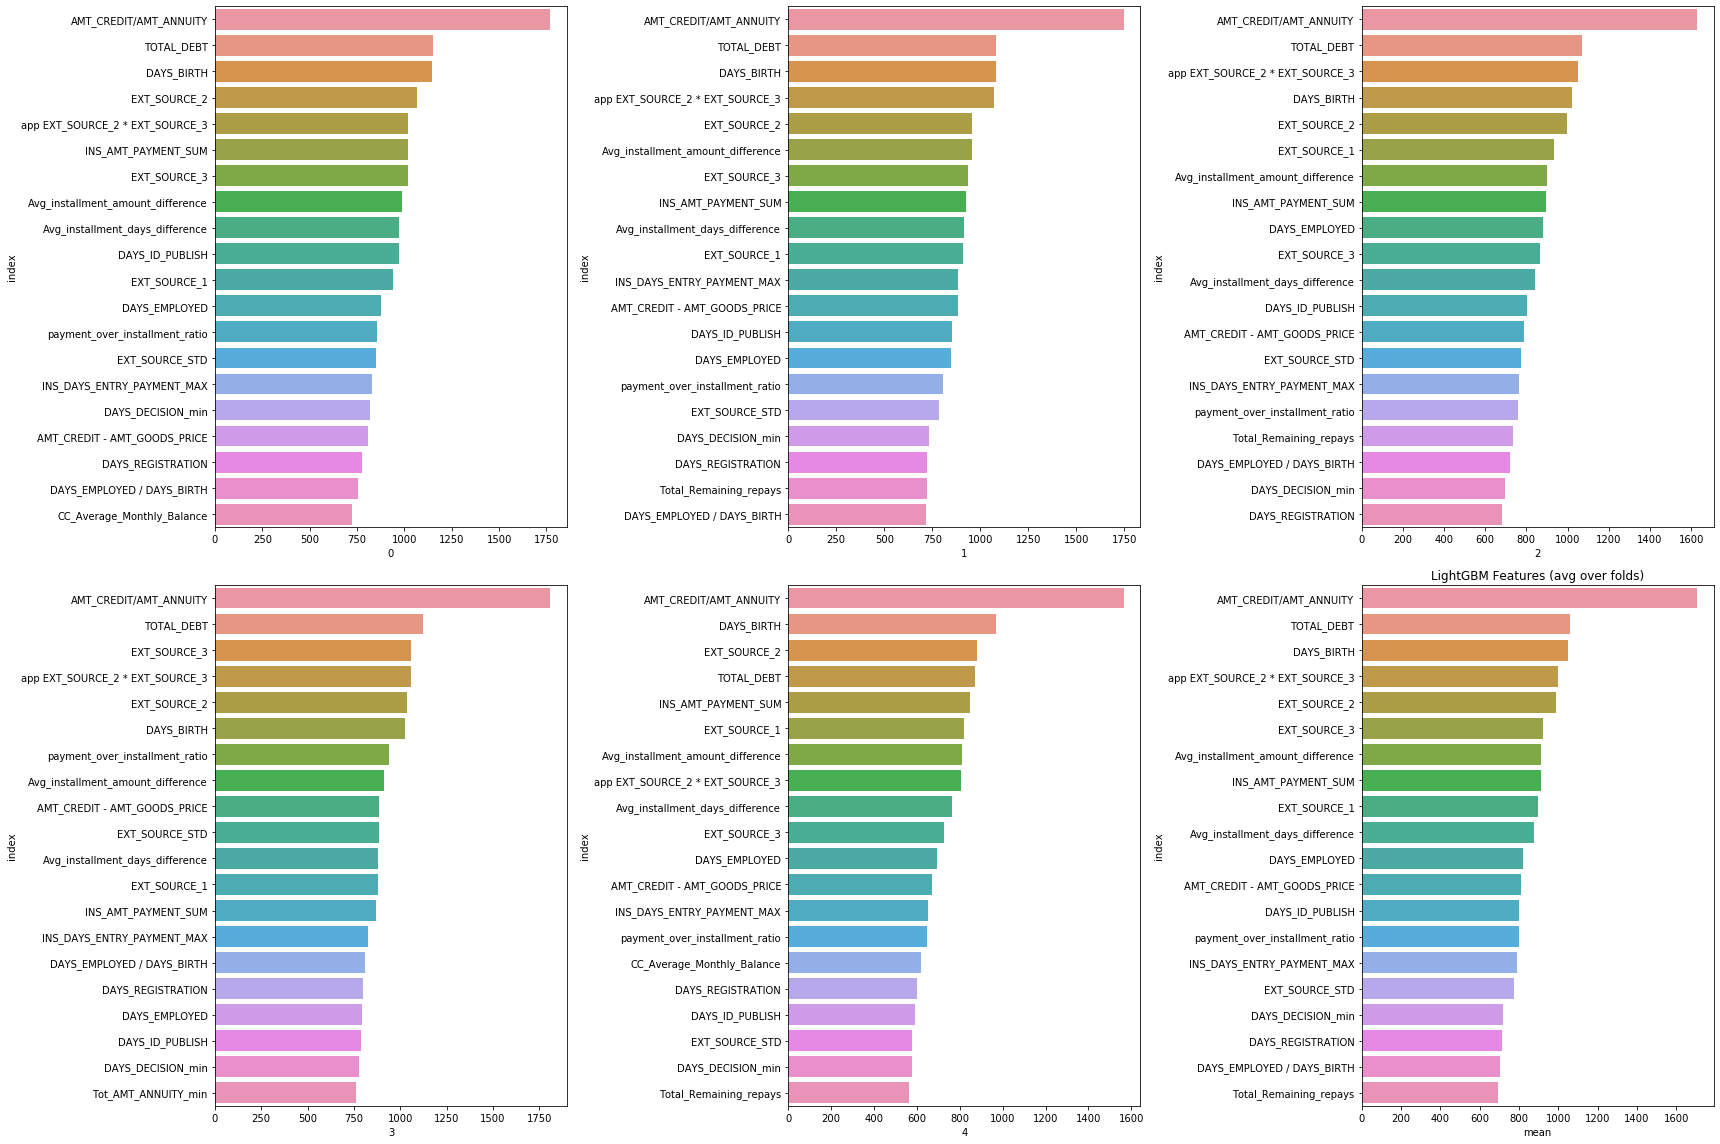

In [667]:
display_folds_importances(feature_importance)

In [668]:
feature_importance[feature_importance['mean'] == 0].shape

(1, 6)

In [669]:
feature_importance.sort_values('mean', ascending = False).head(30)

,0,1,2,3,4,mean
AMT_CREDIT/AMT_ANNUITY,1770,1746,1627,1810,1564,1703.4
TOTAL_DEBT,1151,1080,1070,1124,871,1059.2
DAYS_BIRTH,1145,1080,1020,1024,970,1047.8
app EXT_SOURCE_2 * EXT_SOURCE_3,1020,1071,1049,1056,807,1000.6
EXT_SOURCE_2,1069,959,999,1038,879,988.8
EXT_SOURCE_3,1018,936,868,1058,727,921.4
Avg_installment_amount_difference,988,958,898,913,812,913.8
INS_AMT_PAYMENT_SUM,1020,926,895,868,849,911.6
EXT_SOURCE_1,939,908,932,879,820,895.6
Avg_installment_days_difference,974,916,840,879,764,874.6


In [670]:
# start = time()
lgbm_model = clf.fit(X_train, y_train)
# train_time = np.round(time() - start, 4)

print("LGBM accuracy score: ", np.round(accuracy_score(y_valid, lgbm_model.predict(X_valid)), 3))

print("LGBM roc_auc_score: ", roc_auc_score(y_valid, lgbm_model.predict_proba(X_valid)[:, 1]))

LGBM accuracy score:  0.919
LGBM roc_auc_score:  0.7673357123286985


In [671]:
exp_name = f"LGBM_Advanced_{len(selected_features_phase_3)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, lgbm_model.predict(X_train)), 
                accuracy_score(y_valid, lgbm_model.predict(X_valid)),
                accuracy_score(y_test, lgbm_model.predict(X_test)), 
                roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, lgbm_model.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, lgbm_model.predict_proba(X_test)[:, 1]),
                train_time
                ],4)) 

expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train Time
0,Baseline_106_features,0.9198,0.9192,0.9159,0.7466,0.7445,0.7497,10.0434
1,LogisticRegression_157_features,0.9198,0.9202,0.9163,0.7635,0.7618,0.7631,12.1088
2,LogisticRegression_GSCV_157_features,0.9198,0.9203,0.9163,0.7635,0.7617,0.7631,240.5439
3,RamdomForest_157_features,0.9198,0.9194,0.9160,0.7523,0.7488,0.7489,58.0801
4,RamdomForestCV_157_features,0.9198,0.9194,0.9160,0.8367,0.7596,0.7594,863.3264
5,XGBoost_157_features,0.9286,0.9193,0.9152,0.8845,0.7701,0.7720,72.4219
6,LGBM_157_features,0.9443,0.9200,0.9156,0.9738,0.7732,0.7730,72.4219
7,LGBM_Advanced_157_features,0.9576,0.9187,0.9154,0.9901,0.7663,0.7707,72.4219
8,LGBM_Advanced_158_features,0.9242,0.9142,0.9126,0.8341,0.7110,0.7079,72.4219
9,LGBM_Advanced_163_features,0.9575,0.9187,0.9154,0.9904,0.7673,0.7728,72.4219


# Evaluation metrics

In [449]:
# expLog['exp_name'][1] = 'LogisticRegression_96_features'
# expLog['exp_name'][2] = 'LogisticRegression_GSCV_96_features'
# expLog['exp_name'][3] = 'RandomForest_96_features'
# expLog['exp_name'][4] = 'RandomForestCV_96_features'
# expLog['exp_name'][5] = 'XGBoost_96_features'
# expLog['exp_name'][6] = 'LGBM_96_features'

In [450]:
# expLog

## Submission File Prep

For each SK_ID_CURR in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format:

```python 
SK_ID_CURR,TARGET
100001,0.1
100005,0.9
100013,0.2
etc.
```

In [451]:
# X_kaggle_test

In [452]:
# test_class_scores = lgbm_model.predict_proba(X_kaggle_test)[:, 1]

In [453]:
# test_class_scores[0:10]

In [454]:
# #Submission dataframe
# submit_df = datasets["application_test"][['SK_ID_CURR']]
# submit_df['TARGET'] = test_class_scores

# submit_df.head()

In [455]:
# submit_df.to_csv("LGBM_submission.csv",index=False)
test_prediction_file_name = 'LGBM_submission.csv'

# Kaggle Submission

## report submission

Click on this [link](https://www.kaggle.com/c/home-credit-default-risk/submissions?sortBy=date&group=all&page=1)

<img src="Screen Shot 2020-04-19 at 4.09.55 PM.png">

# Write-up 

## Abstract
Almost everyone, at some point in their life, will need to take out a loan, whether that be for a house, a car, or in an emergency. Unfortunately, for many people that don’t have an established credit history or bank accounts, getting approved for a loan can be a difficult task because the loan company doesn’t have many  traditional metrics on which to base an underwriting decision. The goal of this project is to use alternative data to help aid in predicting whether or not an applicant is likely to repay the loan and thus get approved when they wouldn't otherwise. To tackle this problem our team will utilize the data provided by Home Credit, which consists of various demographic information about the applicant and the area in which they live, as well as data from previous Home Credit loans and loans that were reported to different credit bureaus.
## Introduction
We will experiment with various classification algorithms in order to determine which produces the most accurate predictions. We have the following 7 algorithms so far:Baseline Logistic Regression, Logistic Regression with defaults, Logistic Regression with GridSearch, Random Forest with defaults, Random Forest with RandomizedSearchCV, XGBoot without RandomizedSearchCV, LightGBM without RandomizedSearchCV. We hope to produce a model that will allow Home Credit to successfully predict the likelihood of repayment so that more people can have access to much needed loans.
## Feature Engineering and transformers
We did feature engineering for the application train datasets and the 6 additional datasets.
* We selected top 20 highly correlated features from the application training dataset and 7 categorical features from application train dataset. 
* Then we added additional 39 features from our additional datasets. 
* After one hot coding for the categorical features, we now have in total 96 features selected. 

Please see our num_attribs and  cat_attribs codes below and refer our notebook section 7.1 for details
## Pipelines
1. Build Numeric Pipeline
    * Identify the numeric features we wish to consider.
    * Create a pipeline for the numeric features.
    * Use DataFrameSelector() to select the desired numeric features
    * Use SimpleImputer() for missing data: there are quite a few missing values in the dataset. Missing values will be imputed using the feature median.
    * Use StandardScaler() to standardize the data
    * The numeric pipeline will look like as follows:
    ``` python
    num_pipeline =Pipeline([
           ('selector', DataFrameSelector(num_attribs)),
           ('imputer', SimpleImputer(strategy="median")),
           ('std_scaler', StandardScaler()),
       ])
```
2. Build Categorical Pipeline:
    * Identify the categorical features we wish to consider.
    * Identify the range of expected values for the categorical features.
    * Create a pipeline for the categorical features.
    * Use SimpleImputer() for missing data: there are quite a few missing values in the dataset. Missing values will be imputed using the most frequent values.
    * Then use One Hot Encoding
    * The numeric pipeline will look like as follows:
    ```python 
    cat_pipeline = Pipeline([
           ('selector', DataFrameSelector(cat_attribs)),
           ('imputer', SimpleImputer(strategy='most_frequent')),
           ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
       ])
    ```
3. Union numeric pipeline and categorical pipeline:
    * The codes will looks like as follows:
    ``` python
    full_pipeline = FeatureUnion(transformer_list=[
           ("num_pipeline", num_pipeline),
           ("cat_pipeline", cat_pipeline),
       ])
    ```
4. Use full pipeline above to build full pipeline with our desired algorithm stated above:
    * The codes will looks like as follows:
    ``` python
    full_pipeline = FeatureUnion(transformer_list=[
           ("num_pipeline", num_pipeline),
           ("cat_pipeline", cat_pipeline) ])
    ```
5. Our final pipeline will use full pipeline above to build full pipeline with predictor :
   *  The codes will looks like as follows:
   ``` python
    full_pipeline_with_predictor = Pipeline([
           ("preparation", full_pipeline),
           ("linear", LogisticRegression()) # or any algorithms we selected
       ])
    ```

## Experimental Results

In [456]:
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,Train Time
0,Baseline_106_features,0.9198,0.9192,0.9159,0.7466,0.7445,0.7497,10.0434
1,LogisticRegression_157_features,0.9198,0.9202,0.9163,0.7635,0.7618,0.7631,12.1088
2,LogisticRegression_GSCV_157_features,0.9198,0.9203,0.9163,0.7635,0.7617,0.7631,240.5439
3,RamdomForest_157_features,0.9198,0.9194,0.9160,0.7523,0.7488,0.7489,58.0801
4,RamdomForestCV_157_features,0.9198,0.9194,0.9160,0.8367,0.7596,0.7594,863.3264
5,XGBoost_157_features,0.9286,0.9193,0.9152,0.8845,0.7701,0.7720,72.4219
6,LGBM_157_features,0.9443,0.9200,0.9156,0.9738,0.7732,0.7730,72.4219
7,LGBM_Advanced_157_features,0.9576,0.9187,0.9154,0.9901,0.7663,0.7707,72.4219


## Discussion
1. We have experimented the following 7 models: 
    * Baseline Logistic Regression with 27 features
    * Logistic Regression with 96 features
    * Logistic Regression with GridSearchCV with 96 features
    * Random Forest with 96 features
    * Random Forest with RandomSearchCV with 96 features
    * XGBoost with 96 features
    * LightGBM with 96 features
 
So far our best model is XGBoost with 96 features. Our highest Kaggle scores for it are 0.75106 on private board and 0.74922 on public board. We are excited to see that how quickly the to run Random Forest, XGBoost, and LightGBM models without the additional Hyper parameter tuning and the AUC score is high as well (at least 0.74). We will continue on focusing Hyper parameter tuning of Random Forest, XGBoost, and LightGBM model and additional featuring engineering on Phase 3 and we are excited to see our models will get even higher score.

## Conclusion
We have noticed that XGBoost and LightGBM are performing better than other 5 models (logistic regression and random forest models). It has much higher AUC score and also the train time is not too bad so far

On the Phase 3, we will starting early to train our models so we can have enough time to hyper parameter tuning of Random Forest, XGBoost, and LightGBM models and additional feature engineering. Also we will build our deep learning model. We will also try to use pipelines for our 6 additional datasets, so that we can have a much more organized structure of the datasets and save memory usage as well.

## Kaggle Submission
<img src="Screen Shot 2020-04-19 at 4.09.55 PM.png">